This notebook looks at yields from cusips in the same series as a proof-of-concept for future feature engineering. The logic is simple: cusips in the same series are informative about each other, and providing features that capture that should allow for better accuracy. This should be particularly useful where there is no trade history in the same cusip. 

This notebook does the following, using data from 2023-01:
1. Check the median new_ys, which is the naive estimate for the conditional median, as a baseline MAE benchmark 
2. Calculate the maximum potential accuracy gains from using average new_ys of length X for cusips in the same series without accounting for leakage (trades must be Y seconds ago to be seen in production) 
3. Calculate the realistic accuracy gains from using average new_ys of length X for cusips in the same series with accounting for leakage by masking recent trades 
4. Repeat (3) but excluding trades from the same cusip, since those features are redundant as they are already modelled by the trade history model

Notes on a team member's adjacent work on similar trades:
- similar trades based on bq queries 
- similar trade history fed through separate LSTM, with/without attention, best without attention .2bps 
- last similar trade features (similar to trade hist derived features) 


# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
import os

pd.set_option('max_colwidth', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

# Load data and basic functions

In [3]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [4]:
processed_data = pd.read_pickle('working_dataset.pkl')
processed_data = processed_data.sort_values(by='trade_datetime', ascending=True)
processed_data['cusip_series'] = processed_data['cusip'].str[:6]
# df = processed_data[processed_data.trade_date <= '2023-01-31']

In [5]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-09-29 00:00:00'))

In [6]:
# df = processed_data[processed_data.trade_date >= '2023-07-01']

In [7]:
# df = pd.read_pickle('similar_trades.pkl')

In [8]:
def train_test_split(data):
    print(f'Split the data into train and test sets at a {TRAIN_TEST_SPLIT} train/test ratio')
    train_size = int(len(data) * TRAIN_TEST_SPLIT)
    test_size = len(data) - train_size
    print(f'Train set size: {train_size}\t\tTest set size: {test_size}')
    train_data = data.head(train_size)
    test_data = data.tail(test_size)
    assert train_data.iloc[-1].trade_datetime <= test_data.iloc[0].trade_datetime, 'Most recent trade from the train data should be before the oldest trade from the test data'
    return train_data, test_data

In [118]:
TRAIN_TEST_SPLIT = 0.85
train_data, test_data = train_test_split(df)

Split the data into train and test sets at a 0.85 train/test ratio
Train set size: 703810		Test set size: 124202


In [ ]:
fd = train_data[['cusip','yield','trade_date','coupon']]
grouped = fd.groupby('cusip')
filtered_groups = grouped.filter(lambda group: group['cusip'].size > 10)
filtered_groups

,cusip,yield,trade_date,coupon
11,122547LE0,322.200,2023-01-03,3.250
12,122547LE0,322.200,2023-01-03,3.250
14,54466HJL1,259.000,2023-01-03,5.000
13,54466HJL1,259.000,2023-01-03,5.000
17,54466HJJ6,255.000,2023-01-03,5.000
...,...,...,...,...
703785,64972C7J6,412.200,2023-01-26,4.000
703792,4424354C4,260.000,2023-01-26,5.000
703811,7962532J0,239.600,2023-01-26,5.250
703810,7962532J0,260.000,2023-01-26,5.250


## Simple Rolling Mean (no masking):

this is just a proof of concept, with known leakage

In [118]:
%%time
series_cols = []
cusip_cols = []
for i in [1,2,5,10,15,20, 30, 50]:
    series_cols.append(f'series_mean_last_{i}')
    cusip_cols.append(f'cusip_mean_last_{i}')
    #closed='left' masks the current trade, so no leakage on that front, only leakage from recent trades 
    df[series_cols[-1]] = df.groupby('cusip_series')['new_ys'].rolling(i, min_periods=1, closed= "left").mean().droplevel(0) #using all cusips in series
    df[cusip_cols[-1]] = df.groupby('cusip')['new_ys'].rolling(i, min_periods=1, closed= "left").mean().droplevel(0) #only using same cusip in series 

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 15.7 µs


In [324]:
df[series_cols] = df[series_cols].fillna(0)
df[cusip_cols] = df[cusip_cols].fillna(0)

In [121]:
median_baseline = mean_absolute_error(test_data["new_ys"], np.repeat(train_data["new_ys"].median(), len(test_data)))
print(f'Baseline MAE using Median: {median_baseline:.3f}')
mean_baseline = mean_absolute_error(test_data["new_ys"], np.repeat(train_data["new_ys"].mean(), len(test_data)))
print(f'Baseline MAE using Mean: {mean_baseline:.3f}')
for col1, col2 in zip(series_cols, cusip_cols):
    print(f'MAE using {col1}: {mean_absolute_error(test_data["new_ys"], test_data[col1]):.3f}')
    print(f'MAE using {col2}: {mean_absolute_error(test_data["new_ys"], test_data[col2]):.3f}')

Baseline MAE using Median: 54.326
Baseline MAE using Mean: 54.500
MAE using series_mean_last_1: 32.639
MAE using cusip_mean_last_1: 21.579
MAE using series_mean_last_2: 37.626
MAE using cusip_mean_last_2: 22.773
MAE using series_mean_last_5: 41.259
MAE using cusip_mean_last_5: 23.714
MAE using series_mean_last_10: 42.225
MAE using cusip_mean_last_10: 24.123
MAE using series_mean_last_15: 42.462
MAE using cusip_mean_last_15: 24.327
MAE using series_mean_last_20: 42.618
MAE using cusip_mean_last_20: 24.459
MAE using series_mean_last_30: 42.815
MAE using cusip_mean_last_30: 24.632
MAE using series_mean_last_50: 42.961
MAE using cusip_mean_last_50: 24.812


In [120]:
# median_baseline = mean_absolute_error(test_data["new_ys"], np.repeat(train_data["new_ys"].median(), len(df)))
# print(f'Baseline MAE using Median: {median_baseline:.3f}')
# mean_baseline = mean_absolute_error(test_data["new_ys"], np.repeat(train_data["new_ys"].mean(), len(df)))
# print(f'Baseline MAE using Mean: {mean_baseline:.3f}')
# for col1, col2 in zip(series_cols, cusip_cols):
#     print(f'MAE using {col1}: {mean_absolute_error(test_data["new_ys"], test_data[col1]):.3f}')
#     print(f'MAE using {col2}: {mean_absolute_error(test_data["new_ys"], test_data[col2]):.3f}')

In [187]:
df[df.cusip_series=='115085'][['cusip', 'trade_datetime', 'new_ys','ex_cusip_masked_series_average_1']].head(15)

,cusip,trade_datetime,new_ys,ex_cusip_masked_series_average_1
0,115085AY8,2023-01-03 06:00:02,-15.442,0.000
39765,115085AR3,2023-01-03 16:12:30,41.711,-15.442
39766,115085AR3,2023-01-03 16:12:30,42.211,-15.442
39767,115085AR3,2023-01-03 16:12:30,27.511,-15.442
39769,115085AR3,2023-01-03 16:12:30,38.411,-15.442
49908,115085AB8,2023-01-04 10:16:46,20.184,38.411
49953,115085AB8,2023-01-04 10:16:52,25.384,38.411
49958,115085AB8,2023-01-04 10:16:52,20.184,38.411
49959,115085AB8,2023-01-04 10:16:52,14.084,38.411
87339,115085AM4,2023-01-04 16:06:33,51.781,14.084


## Simple rolling mean without leakage:
masking <= 60seconds trades in the same series

### Rolling function definitions and time trials:

In [5]:
import multiprocessing
wrapper = None
#using a wrapper function for mp.pool is convenient, but it must be instantiated before pool otherwise mp.pool.map will throw an "AttributeError: Can't pickle local object"
#a quick and easy fix is just to define wrapper first then reassign it to the wrapper function later on 

def _masked_fuction(data, agg_func, target_col = 'new_ys', max_sequence_length = 5, seconds_ago_mask = 60):
    '''Applies a function to target_col while masking trades less than X seconds ago.'''
    
    row_id = data.iloc[-1]['id']
    target_datetime = data.iloc[-1]['trade_datetime']
    data = data.iloc[:-1]  
    data = data[(target_datetime - data['trade_datetime']).dt.total_seconds() >= seconds_ago_mask]
    if len(data) == 0: 
        return row_id, 0
    return row_id, agg_func(data.iloc[-max_sequence_length:][target_col])

def _masked_fuction_ex_cusip(data, agg_func, target_col = 'new_ys', max_sequence_length = 5, seconds_ago_mask = 60):
    '''Applies a function to target_col while masking trades less than X seconds ago.'''
    
    row_id = data.iloc[-1]['id']
    target_datetime, target_cusip = data.iloc[-1][['trade_datetime', 'cusip']].values
    data = data.iloc[:-1]  
    data = data[(target_datetime - data['trade_datetime']).dt.total_seconds() >= seconds_ago_mask]
    data = data[data.cusip!=target_cusip]
    if len(data) == 0: 
        return row_id, 0
    return row_id, agg_func(data.tail(max_sequence_length)[target_col])

def calculate_masked_func(data, agg_func, ex_cusip = False, groupby_col = 'cusip_series', target_col = 'new_ys', max_sequence_length = 5, seconds_ago_mask = 60, mp = None, max_window = 100):
    '''
    Calculates average of target_col while masking trades less than X seconds ago with option for multiprocessing.
    '''
    
    
    if mp is not None and not isinstance(mp, int):
        raise TypeError(f'mp must be an integer for number of jobs for mp.pool, instead got mp = {mp} of type {type(mp)}')
        
    data['id'] = range(len(data))
    groupby = data.groupby(groupby_col).rolling(max_window, min_periods=0)
    resample = list(groupby) 
    
    if ex_cusip:
        func = _masked_fuction_ex_cusip
    else: 
        func = _masked_fuction
        
    if not mp:
        result = [func(x, 
                      agg_func,
                      target_col = target_col,
                      max_sequence_length = max_sequence_length,
                      seconds_ago_mask = seconds_ago_mask)
              for x in resample]
    else:
        global wrapper
        def wrapper(x):
            '''Wrapper function for func that takes only one argument foreasier compatibility with mp.pool'''
            return func(x, 
                      agg_func,
                      target_col = target_col,
                      max_sequence_length = max_sequence_length,
                      seconds_ago_mask = seconds_ago_mask)
            
        with multiprocessing.Pool(processes=mp) as pool:  
            result = pool.map(wrapper, resample)

    data.drop('id', axis = 1, inplace=True)    
    return pd.Series({key: value for key, value in result})

def calculate_masked_average(data, ex_cusip = False, groupby_col = 'cusip_series', target_col = 'new_ys', max_sequence_length = 5, seconds_ago_mask = 60, mp = None, max_window = 100):
    return calculate_masked_func(data, 
                                 lambda y: y.mean(), 
                                 ex_cusip = ex_cusip, 
                                 groupby_col = groupby_col, 
                                 target_col = target_col, 
                                 max_sequence_length = max_sequence_length, 
                                 seconds_ago_mask = seconds_ago_mask, 
                                 mp = mp, 
                                 max_window = max_window)

In [6]:
def run_trial(N, do_all = True):
    toy = df.iloc[:N].copy()
    toy.reset_index(drop=True, inplace=True)
    if do_all:
        %time temp1 = calculate_masked_average(toy[['trade_datetime','cusip_series','new_ys']])
        %time temp2 = calculate_masked_average(toy[['trade_datetime','cusip_series','new_ys']], mp = 4)
    %time temp3 = calculate_masked_average(toy[['trade_datetime','cusip_series','new_ys']], mp = 16)
    %time temp4 = calculate_masked_average(toy[['trade_datetime','cusip_series','new_ys']], mp = multiprocessing.cpu_count() - 1)

In [195]:
run_trial(1000)

CPU times: user 2.37 s, sys: 0 ns, total: 2.37 s
Wall time: 2.38 s
CPU times: user 296 ms, sys: 604 ms, total: 899 ms
Wall time: 1.8 s
CPU times: user 159 ms, sys: 2.87 s, total: 3.03 s
Wall time: 3.87 s
CPU times: user 115 ms, sys: 5.31 s, total: 5.42 s
Wall time: 5.84 s


In [196]:
run_trial(10000)

CPU times: user 12.9 s, sys: 0 ns, total: 12.9 s
Wall time: 12.8 s
CPU times: user 1.22 s, sys: 109 ms, total: 1.33 s
Wall time: 4.62 s
CPU times: user 884 ms, sys: 1.86 s, total: 2.75 s
Wall time: 3.62 s
CPU times: user 1.87 s, sys: 3.62 s, total: 5.49 s
Wall time: 5.95 s


In [197]:
run_trial(50000)

CPU times: user 1min 21s, sys: 0 ns, total: 1min 21s
Wall time: 1min 21s
CPU times: user 11.6 s, sys: 0 ns, total: 11.6 s
Wall time: 28.5 s
CPU times: user 8.35 s, sys: 0 ns, total: 8.35 s
Wall time: 11.5 s
CPU times: user 7.75 s, sys: 3.8 s, total: 11.5 s
Wall time: 14.3 s


In [200]:
run_trial(100000)

CPU times: user 2min 41s, sys: 0 ns, total: 2min 41s
Wall time: 2min 41s
CPU times: user 15.3 s, sys: 0 ns, total: 15.3 s
Wall time: 58.2 s
CPU times: user 19.4 s, sys: 0 ns, total: 19.4 s
Wall time: 30.8 s
CPU times: user 19.8 s, sys: 2.23 s, total: 22.1 s
Wall time: 24 s


In [202]:
run_trial(400000, do_all=False)

CPU times: user 1min 1s, sys: 2.91 s, total: 1min 4s
Wall time: 1min 36s
CPU times: user 1min 10s, sys: 3.83 s, total: 1min 14s
Wall time: 1min 28s


In [205]:
%time temp = calculate_masked_average(df[['trade_datetime','cusip_series','new_ys']], mp = multiprocessing.cpu_count() - 1, max_sequence_length = 50)

CPU times: user 2min 13s, sys: 5.17 s, total: 2min 18s
Wall time: 2min 49s


In [211]:
%time temp = calculate_masked_average(df[['trade_datetime', 'cusip', 'cusip_series','new_ys']], ex_cusip=True, mp = multiprocessing.cpu_count() - 1, max_sequence_length = 50)

CPU times: user 2min 53s, sys: 7.21 s, total: 3min
Wall time: 4min 4s


In [ ]:
%time temp = calculate_masked_average(df[['trade_datetime', 'cusip', 'cusip_series','new_ys']], ex_cusip=True, mp = multiprocessing.cpu_count() - 1, max_sequence_length = 50)

In [7]:
import cProfile
def profile_decorator(func):
    def inner_wrapper(*args, **kwargs):
        profile = cProfile.Profile()
        profile.enable()

        result = func(*args, **kwargs)

        profile.disable()
        profile.print_stats(sort='cumulative')

        return result

    return inner_wrapper

@profile_decorator
def timed_trial(N):
    toy = df.iloc[:N].copy()
    toy.reset_index(drop=True, inplace=True)
    temp1 = calculate_masked_average(toy[['trade_datetime','cusip_series','new_ys']])

### Further Optimization:

In [8]:
import multiprocessing
wrapper = None
#using a wrapper function for mp.pool is convenient, but it must be instantiated before pool otherwise mp.pool.map will throw an "AttributeError: Can't pickle local object"
#a quick and easy fix is just to define wrapper first then reassign it to the wrapper function later on 

def _masked_fuction_2(data, agg_func, windows, mask_cusip = False, target_col = 'new_ys', seconds_ago_mask = 60):
    '''Applies a function to target_col while masking trades less than X seconds ago.'''
    
    row_id = data.iloc[-1]['id']
    target_datetime = data.iloc[-1]['trade_datetime']
    target_cusip = data.iloc[-1]['cusip']
    data = data.iloc[:-1]  
    data = data[(target_datetime - data['trade_datetime']).dt.total_seconds() >= seconds_ago_mask]
    if mask_cusip:
        data = data[data.cusip!=target_cusip]
    if len(data) == 0: 
        return row_id, None
    f = lambda size: agg_func(data.iloc[-size:][target_col])
    res = list(map(f, windows))
    return row_id, res

def calculate_masked_func_2(data, agg_func, windows, mask_cusip = False, groupby_col = 'cusip_series', target_col = 'new_ys', seconds_ago_mask = 60, mp = None, max_window = 100):
    '''
    Calculates average of target_col while masking trades less than X seconds ago with option for multiprocessing.
    '''
    
    
    if mp is not None and not isinstance(mp, int):
        raise TypeError(f'mp must be an integer for number of jobs for mp.pool, instead got mp = {mp} of type {type(mp)}')
        
    data['id'] = range(len(data))
    groupby = data.groupby(groupby_col).rolling(max_window, min_periods=0)
    resample = list(groupby) 

        
    if not mp:
        result = [_masked_fuction_2(data=x, 
                                    agg_func = agg_func,
                                    windows = windows,
                                    mask_cusip = mask_cusip,
                                    target_col = target_col,
                                    seconds_ago_mask = seconds_ago_mask)
              for x in resample]
    else:
        global wrapper
        def wrapper(x):
            '''Wrapper function for func that takes only one argument foreasier compatibility with mp.pool'''
            return _masked_fuction_2(data=x, 
                                        agg_func = agg_func,
                                        windows = windows,
                                        mask_cusip = mask_cusip,
                                        target_col = target_col,
                                        seconds_ago_mask = seconds_ago_mask)
            
        with multiprocessing.Pool(processes=mp) as pool:  
            result = pool.map(wrapper, resample)

    data.drop('id', axis = 1, inplace=True)    
    return pd.Series({key: value for key, value in result})

def calculate_masked_average_2(data, windows, mask_cusip = False, groupby_col = 'cusip_series', target_col = 'new_ys', seconds_ago_mask = 60, mp = None, max_window = 100):
    return calculate_masked_func_2(data = data, 
                                 agg_func = lambda y: y.mean(), 
                                 windows = windows,
                                 mask_cusip = mask_cusip, 
                                 groupby_col = groupby_col, 
                                 target_col = target_col, 
                                 seconds_ago_mask = seconds_ago_mask, 
                                 mp = mp, 
                                 max_window = max_window)

In [ ]:
%%time
res = []
masked_cols = [f'ex_cusip_masked_series_average_{i}' for i in [1,2,5,10,15,20,30,50]]
for i in [1,2, 5, 10, 15, 20, 30, 50]:
    %time temp = calculate_masked_average(df[['trade_datetime', 'cusip', 'cusip_series','new_ys']], ex_cusip=True, mp = multiprocessing.cpu_count() - 1,max_sequence_length = i)
    res.append(temp)
df[masked_cols] = pd.concat(res, axis = 1) 

In [150]:
N = 100000
toy = df.iloc[:N]
%time temp1 = calculate_masked_average_2(toy, [1], mask_cusip=True)
%time temp2 = calculate_masked_average_2(toy, [1,2,5], mask_cusip=True)
%time temp3 = calculate_masked_average_2(toy, [1], mask_cusip=True, mp = 4)
%time temp4 = calculate_masked_average_2(toy, [1,2,5], mask_cusip=True, mp = 4)

CPU times: user 5min 52s, sys: 998 ms, total: 5min 53s
Wall time: 5min 53s
CPU times: user 6min 31s, sys: 286 ms, total: 6min 32s
Wall time: 6min 32s
CPU times: user 55.6 s, sys: 13.9 s, total: 1min 9s
Wall time: 2min 47s
CPU times: user 28.6 s, sys: 4.93 s, total: 33.5 s
Wall time: 2min 7s


In [171]:
%time temp4 = calculate_masked_average_2(toy, [1,2,5], mask_cusip=True, mp = multiprocessing.cpu_count() - 1)

CPU times: user 30.6 s, sys: 16.5 s, total: 47.1 s
Wall time: 52.6 s


In [201]:
%time temp5 = calculate_masked_average_2(df.iloc[:500000][['trade_datetime','cusip','cusip_series','new_ys']], [1, 2, 10,15, 20, 30, 50], mask_cusip=True, mp = multiprocessing.cpu_count() - 1)

CPU times: user 1min 48s, sys: 17.5 s, total: 2min 5s
Wall time: 3min 34s


In [9]:
def to_df(series):
    temp = series.copy()
    fill_size = len(temp.dropna().iloc[0])
    fill_list = [0 for _ in range(fill_size)]
    temp.loc[temp.isna()] = temp.loc[temp.isna()].apply(lambda x: fill_list)
    return pd.DataFrame(temp.to_list(), index=temp.index)

### Application and Analysis:

In [315]:
%%time
df.reset_index(drop=True, inplace=True)
temp = calculate_masked_average(df[['trade_datetime','cusip_series','new_ys']])
df['masked_series_average_5'] = temp

CPU times: user 22min 12s, sys: 1.2 s, total: 22min 13s
Wall time: 22min 14s


In [330]:
%%time
df.reset_index(drop=True, inplace=True)
temp = calculate_masked_average(df[['trade_datetime','cusip','new_ys']], groupby_col='cusip')
df['masked_cusip_average_5'] = temp

CPU times: user 21min 28s, sys: 1.12 s, total: 21min 29s
Wall time: 21min 29s


In [333]:
%%time
for i in [1,2, 10,15,20, 30, 50]:
    temp = calculate_masked_average(df[['trade_datetime','cusip_series','new_ys']], max_sequence_length = i)
    df[f'masked_series_average_{i}'] = temp

CPU times: user 2h 35min 51s, sys: 8.46 s, total: 2h 36min
Wall time: 2h 36min 6s


In [335]:
for i in [1,2, 10,15,20, 30, 50]:
    print(f'masked_series_average_{i}: {mean_absolute_error(df["new_ys"], df[f"masked_series_average_{i}"]):3f}')

masked_series_average_1: 49.789678
masked_series_average_2: 48.607362
masked_series_average_10: 44.738403
masked_series_average_15: 44.297552
masked_series_average_20: 44.058594
masked_series_average_30: 43.856427
masked_series_average_50: 43.769231


In [22]:
%%time
res = []
masked_cols = [f'ex_cusip_masked_series_average_{i}' for i in [1,2,5,10,15,20,30,50]]
for i in [1,2, 5, 10, 15, 20, 30, 50]:
    %time temp = calculate_masked_average(df[['trade_datetime', 'cusip', 'cusip_series','new_ys']], ex_cusip=True, mp = multiprocessing.cpu_count() - 1,max_sequence_length = i)
    res.append(temp)
df[masked_cols] = pd.concat(res, axis = 1) 

CPU times: user 2min 46s, sys: 8.72 s, total: 2min 55s
Wall time: 3min 54s
CPU times: user 2min 45s, sys: 8.48 s, total: 2min 53s
Wall time: 4min 7s
CPU times: user 2min 48s, sys: 8.42 s, total: 2min 57s
Wall time: 4min 9s
CPU times: user 2min 54s, sys: 8.66 s, total: 3min 3s
Wall time: 4min 16s
CPU times: user 2min 48s, sys: 9.32 s, total: 2min 57s
Wall time: 4min 5s
CPU times: user 2min 46s, sys: 12.5 s, total: 2min 58s
Wall time: 3min 54s
CPU times: user 2min 49s, sys: 10.3 s, total: 2min 59s
Wall time: 3min 59s
CPU times: user 2min 45s, sys: 10.3 s, total: 2min 55s
Wall time: 3min 52s
CPU times: user 22min 25s, sys: 1min 16s, total: 23min 41s
Wall time: 32min 20s


In [36]:
for i in [1,2, 10,15,20, 30, 50]:
    print(f'ex_cusip_masked_series_average_{i}: {mean_absolute_error(df["new_ys"], df[f"ex_cusip_masked_series_average_{i}"]):3f}')

ex_cusip_masked_series_average_1: 59.117016
ex_cusip_masked_series_average_2: 57.200173
ex_cusip_masked_series_average_10: 51.364681
ex_cusip_masked_series_average_15: 50.571629
ex_cusip_masked_series_average_20: 50.134837
ex_cusip_masked_series_average_30: 49.708728
ex_cusip_masked_series_average_50: 49.360656


Simple autoregression with ols and quantile rgression:

In [10]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

def perform_ols(train_data, test_data, predictors, target='new_ys', print_result = True, return_vals = False):
    '''Estimates OLS model using statsmodels api with predefined set of predictors'''
    x = sm.add_constant(train_data[predictors])
    y = train_data[target]
    lm = sm.OLS(y, x).fit()
    preds = lm.predict(sm.add_constant(test_data[predictors]))
    
    
    if print_result: 
        print(F'OLS MAE using features {predictors}: \n{mean_absolute_error(test_data[target], preds):3f}')
        display(lm.summary())
    if return_vals: 
        return lm, mean_absolute_error(test_data[target], preds)
    
def perform_qreg(train_data, test_data, predictors, target='new_ys', print_result = True, return_vals = False):
    '''Estimates 50th quantile model using statsmodels smf api with predefined set of predictors. Equivalent to minimizing MAE'''
    x = sm.add_constant(train_data[predictors])
    y = train_data[target]
    lm = QuantReg(y, x).fit()
    preds = lm.predict(sm.add_constant(test_data[predictors]))
    
    if print_result: 
        print(F'OLS MAE using features {predictors}: \n{mean_absolute_error(test_data[target], preds):3f}')
        display(lm.summary())
    if return_vals: 
        return lm, mean_absolute_error(test_data[target], preds)

In [11]:
masked_cols = [f'ex_cusip_masked_series_average_{i}' for i in [1,2,5,10,15,20,30,50]]
permutations = []
def permute(path, masked_cols):
    global permutations
    for i, col in enumerate(masked_cols):
        new_path = path + [col]
        permutations.append(new_path)
        permute(new_path, masked_cols[i+1:])
permute([], masked_cols)
print(len(permutations))

255


In [101]:
%%time 
summary_df = pd.DataFrame()
for cols in permutations:
    lm, mae = perform_ols(train_data,
                          test_data,
                          cols,
                         print_result=False,
                         return_vals=True)
    summary_df = summary_df.append({'ncols': len(cols), 'cols': cols, 'MAE':mae, 'model':lm}, ignore_index=True)

CPU times: user 11min 26s, sys: 14min 11s, total: 25min 38s
Wall time: 1min 15s


In [218]:
# %%time 
# def _qreg_helper(col):
#     return perform_qreg(train_data, test_data, col, print_result = False, return_vals = True)

# summary_df_qreg = pd.DataFrame()
# with multiprocessing.Pool(processes=4) as pool:  
#     result = pool.map(_qreg_helper, permutations)
    
#     # summary_df = summary_df.append({'ncols': len(cols), 'cols': cols, 'MAE':mae, 'model':lm}, ignore_index=True)

In [223]:
%%time 
summary_df2 = pd.DataFrame()
for cols in permutations:
    lm, mae = perform_qreg(train_data,
                          test_data,
                          cols,
                         print_result=False,
                         return_vals=True)
    summary_df2 = summary_df2.append({'ncols': len(cols), 'cols': cols, 'MAE':mae, 'model':lm}, ignore_index=True)
    

CPU times: user 10h 41min 34s, sys: 13h 10min 55s, total: 23h 52min 29s
Wall time: 1h 11min 11s


In [226]:
summary_df.sort_values('MAE')

,ncols,cols,MAE,model
54,5.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_15, ex_cusip_masked_series_average_20, ex_cusip_masked_series_average_50]",50.092,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04dffd10>
23,6.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_5, ex_cusip_masked_series_average_15, ex_cusip_masked_series_average_20, ex_cusip_masked_series_average_50]",50.092,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d050810d0>
117,4.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_15, ex_cusip_masked_series_average_20, ex_cusip_masked_series_average_50]",50.092,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04871890>
61,4.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_20, ex_cusip_masked_series_average_50]",50.092,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04e6a610>
30,5.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_5, ex_cusip_masked_series_average_20, ex_cusip_masked_series_average_50]",50.092,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04d40ed0>
...,...,...,...,...
129,2.000,"[ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_5]",51.748,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04859e10>
192,1.000,[ex_cusip_masked_series_average_5],51.750,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04928110>
1,2.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_2]",52.415,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04a5dfd0>
128,1.000,[ex_cusip_masked_series_average_2],52.418,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d048590d0>


In [225]:
summary_df2.sort_values('MAE')

,ncols,cols,MAE,model
105,4.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_10, ex_cusip_masked_series_average_15, ex_cusip_masked_series_average_50]",48.916,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04d14950>
112,3.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_10, ex_cusip_masked_series_average_50]",48.916,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d057dc050>
104,5.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_10, ex_cusip_masked_series_average_15, ex_cusip_masked_series_average_30, ex_cusip_masked_series_average_50]",48.917,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04d14490>
42,5.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_10, ex_cusip_masked_series_average_15, ex_cusip_masked_series_average_50]",48.917,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fa04c816dd0>
101,6.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_10, ex_cusip_masked_series_average_15, ex_cusip_masked_series_average_20, ex_cusip_masked_series_average_30, ex_cusip_masked_series_average_50]",48.917,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04d14c50>
...,...,...,...,...
129,2.000,"[ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_5]",50.649,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04d2a490>
192,1.000,[ex_cusip_masked_series_average_5],50.651,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04798b50>
128,1.000,[ex_cusip_masked_series_average_2],51.606,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04d22750>
1,2.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_2]",51.609,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9fffb31610>


In [227]:
summary_df[summary_df.cols.apply(len) == 1].sort_values('MAE')

,ncols,cols,MAE,model
254,1.000,[ex_cusip_masked_series_average_50],50.113,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0466e890>
252,1.000,[ex_cusip_masked_series_average_30],50.325,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0493ae90>
248,1.000,[ex_cusip_masked_series_average_20],50.549,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0493a110>
240,1.000,[ex_cusip_masked_series_average_15],50.742,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0494a050>
224,1.000,[ex_cusip_masked_series_average_10],51.135,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0496e590>
192,1.000,[ex_cusip_masked_series_average_5],51.750,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04928110>
128,1.000,[ex_cusip_masked_series_average_2],52.418,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d048590d0>
0,1.000,[ex_cusip_masked_series_average_1],52.646,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04a5dcd0>


In [228]:
summary_df2[summary_df2.cols.apply(len) == 1].sort_values('MAE')

,ncols,cols,MAE,model
254,1.000,[ex_cusip_masked_series_average_50],48.958,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d050b25d0>
252,1.000,[ex_cusip_masked_series_average_30],49.167,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d050b2f50>
248,1.000,[ex_cusip_masked_series_average_20],49.357,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04709290>
240,1.000,[ex_cusip_masked_series_average_15],49.541,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04e31e90>
224,1.000,[ex_cusip_masked_series_average_10],49.909,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d093e4a10>
192,1.000,[ex_cusip_masked_series_average_5],50.651,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04798b50>
128,1.000,[ex_cusip_masked_series_average_2],51.606,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04d22750>
0,1.000,[ex_cusip_masked_series_average_1],51.977,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d05f00610>


In [133]:
summary_df[summary_df.cols.apply(len) == 2].sort_values('MAE')

,ncols,cols,MAE,model
127,2.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_50]",50.093,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04869350>
191,2.000,"[ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_50]",50.096,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d049288d0>
223,2.000,"[ex_cusip_masked_series_average_5, ex_cusip_masked_series_average_50]",50.110,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0496e050>
239,2.000,"[ex_cusip_masked_series_average_10, ex_cusip_masked_series_average_50]",50.111,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d04957350>
247,2.000,"[ex_cusip_masked_series_average_15, ex_cusip_masked_series_average_50]",50.112,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0493a8d0>
251,2.000,"[ex_cusip_masked_series_average_20, ex_cusip_masked_series_average_50]",50.113,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0493acd0>
253,2.000,"[ex_cusip_masked_series_average_30, ex_cusip_masked_series_average_50]",50.121,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0493add0>
125,2.000,"[ex_cusip_masked_series_average_1, ex_cusip_masked_series_average_30]",50.298,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d048698d0>
189,2.000,"[ex_cusip_masked_series_average_2, ex_cusip_masked_series_average_30]",50.304,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d049345d0>
221,2.000,"[ex_cusip_masked_series_average_5, ex_cusip_masked_series_average_30]",50.319,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d0496e7d0>


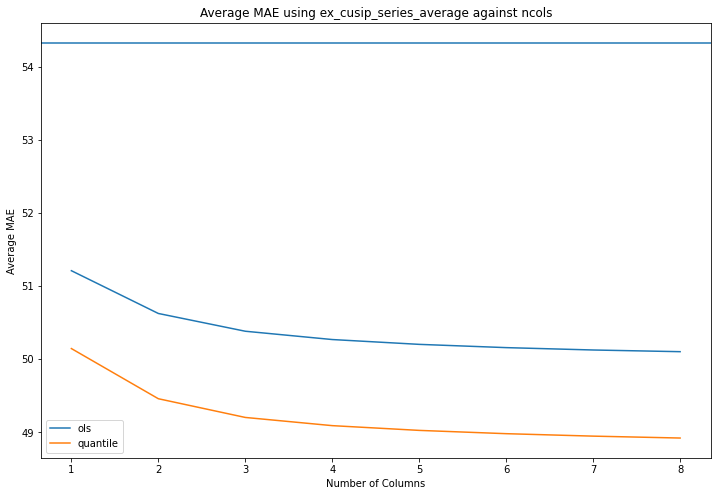

In [231]:
fig, ax = plt.subplots(figsize=(12,8))
summary_df.groupby('ncols')['MAE'].mean().plot(ax=ax, label='ols');
summary_df2.groupby('ncols')['MAE'].mean().plot(ax=ax, label='quantile');
ax.set_ylabel('Average MAE');
ax.set_xlabel('Number of Columns');
ax.set_title('Average MAE using ex_cusip_series_average against ncols');
ax.axhline(mean_absolute_error(test_data["new_ys"], np.repeat(train_data["new_ys"].median(), len(test_data))));
ax.legend();

In [74]:
perform_ols(train_data, 
            test_data, 
            train_data.filter(regex='ex_cusip_masked_series_average').columns.tolist()
           )

perform_ols(train_data, 
            test_data, 
            train_data.filter(regex='ex_cusip_masked_series_average').columns.tolist()[1:]
           )

OLS MAE using features ['ex_cusip_masked_series_average_1', 'ex_cusip_masked_series_average_2', 'ex_cusip_masked_series_average_5', 'ex_cusip_masked_series_average_10', 'ex_cusip_masked_series_average_15', 'ex_cusip_masked_series_average_20', 'ex_cusip_masked_series_average_30', 'ex_cusip_masked_series_average_50']: 
50.103047


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 new_ys   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     7391.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:30:33   Log-Likelihood:            -4.1594e+06
No. Observations:              703810   AIC:                         8.319e+06
Df Residuals:                  703801   BIC:                         8.319e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                32.2443      0.145    223.015      0.000      31.961      32.528
ex_cusip_masked_series_average_1      0.0388      0.004     10.536      0.000       0.032       0.046
ex_cusip_masked_series_average_2      0.0178      0.005      3.740      0.000       0.008       0.027
ex_cusip_masked_series_average_5      0.0263      0.005      5.641      0.000       0.017       0.035
ex_cusip_masked_series_average_10    -0.0782      0.008    -10.418      0.000      -0.093      -0.063
ex_cusip_masked_series_average_15     0.1017      0.012      8.504      0.000       0.078       0.125
ex_cusip_masked_series_average_20    -0.1035      0.013     -8.238      0.000      -0.128      -0.079
ex_cusip_masked_series_average_30     0.0711      0.013      5.643      0.000       0.046       0.096
ex_cusip_masked_series_average_50     0.4159      0.010     41.187      0.000       0.396       0.436
==============================================================================
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     145679439806.883
Skew:                          29.757   Prob(JB):                         0.00
Kurtosis:                    2231.036   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OLS MAE using features ['ex_cusip_masked_series_average_2', 'ex_cusip_masked_series_average_5', 'ex_cusip_masked_series_average_10', 'ex_cusip_masked_series_average_15', 'ex_cusip_masked_series_average_20', 'ex_cusip_masked_series_average_30', 'ex_cusip_masked_series_average_50']: 
50.105466


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 new_ys   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     8430.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:30:33   Log-Likelihood:            -4.1594e+06
No. Observations:              703810   AIC:                         8.319e+06
Df Residuals:                  703802   BIC:                         8.319e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                32.2468      0.145    223.015      0.000      31.963      32.530
ex_cusip_masked_series_average_2      0.0599      0.003     23.249      0.000       0.055       0.065
ex_cusip_masked_series_average_5      0.0166      0.005      3.642      0.000       0.008       0.026
ex_cusip_masked_series_average_10    -0.0753      0.008    -10.034      0.000      -0.090      -0.061
ex_cusip_masked_series_average_15     0.1001      0.012      8.365      0.000       0.077       0.124
ex_cusip_masked_series_average_20    -0.1040      0.013     -8.271      0.000      -0.129      -0.079
ex_cusip_masked_series_average_30     0.0736      0.013      5.841      0.000       0.049       0.098
ex_cusip_masked_series_average_50     0.4178      0.010     41.377      0.000       0.398       0.438
==============================================================================
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     145489709677.470
Skew:                          29.744   Prob(JB):                         0.00
Kurtosis:                    2229.584   Cond. No.                         267.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Work in progress ideas:

## Simple autoregression with added features:
- max & min
- within-cusip normalized volatility using cusip-level ARCH?
- lifetime volatility (?)


In [44]:
mp = multiprocessing.cpu_count()/2
# mp  = 4 
series_features = {'series_max': lambda data: calculate_masked_func(data, lambda y: y.max(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_min': lambda data: calculate_masked_func(data, lambda y: y.min(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_std': lambda data: calculate_masked_func(data, lambda y: y.median(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_vol': lambda data: calculate_masked_func(data, lambda y: y.std(), ex_cusip = True, max_sequence_length = 10, mp = mp)}

combined_features = lambda data: calculate_masked_func(data, lambda y: (y.max(), y.min(), y.median(), y.std()), ex_cusip = True, max_sequence_length = 10, mp = mp)
new_cols = list(series_features.keys())

In [116]:
%%time

res = combined_features(df)
res.loc[res==0] = [(0,0,0,0) for _ in range(sum(res==0))]
df[new_cols] = pd.DataFrame(res.to_list(), index=res.index)

CPU times: user 6min 39s, sys: 50.3 s, total: 7min 29s
Wall time: 8min 41s


In [129]:
for col in new_cols:
    df[col] = df[col].fillna(0)

In [130]:
ex_cusip_cols = ['ex_cusip_masked_series_average_1',
                 'ex_cusip_masked_series_average_2',
                 'ex_cusip_masked_series_average_5',
                 'ex_cusip_masked_series_average_10',
                 'ex_cusip_masked_series_average_15',
                 'ex_cusip_masked_series_average_20',
                 'ex_cusip_masked_series_average_30',
                 'ex_cusip_masked_series_average_50']

In [132]:
perform_ols(train_data, 
            test_data, 
            ex_cusip_cols
           )

OLS MAE using features ['ex_cusip_masked_series_average_1', 'ex_cusip_masked_series_average_2', 'ex_cusip_masked_series_average_5', 'ex_cusip_masked_series_average_10', 'ex_cusip_masked_series_average_15', 'ex_cusip_masked_series_average_20', 'ex_cusip_masked_series_average_30', 'ex_cusip_masked_series_average_50']: 
50.020145


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 new_ys   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     7498.
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:58:53   Log-Likelihood:            -4.1590e+06
No. Observations:              703810   AIC:                         8.318e+06
Df Residuals:                  703801   BIC:                         8.318e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                31.8315      0.145    219.163      0.000      31.547      32.116
ex_cusip_masked_series_average_1      0.0399      0.004     10.888      0.000       0.033       0.047
ex_cusip_masked_series_average_2      0.0166      0.005      3.492      0.000       0.007       0.026
ex_cusip_masked_series_average_5      0.0224      0.005      4.838      0.000       0.013       0.031
ex_cusip_masked_series_average_10    -0.0648      0.007     -8.657      0.000      -0.079      -0.050
ex_cusip_masked_series_average_15     0.0960      0.012      8.070      0.000       0.073       0.119
ex_cusip_masked_series_average_20    -0.1037      0.013     -8.292      0.000      -0.128      -0.079
ex_cusip_masked_series_average_30     0.0768      0.012      6.418      0.000       0.053       0.100
ex_cusip_masked_series_average_50     0.4132      0.009     44.830      0.000       0.395       0.431
==============================================================================
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     146395270104.647
Skew:                          29.805   Prob(JB):                         0.00
Kurtosis:                    2236.504   Cond. No.                         291.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
perform_ols(train_data, 
            test_data, 
            ex_cusip_cols + new_cols
           )

OLS MAE using features ['ex_cusip_masked_series_average_1', 'ex_cusip_masked_series_average_2', 'ex_cusip_masked_series_average_5', 'ex_cusip_masked_series_average_10', 'ex_cusip_masked_series_average_15', 'ex_cusip_masked_series_average_20', 'ex_cusip_masked_series_average_30', 'ex_cusip_masked_series_average_50', 'series_max', 'series_min', 'series_std', 'series_vol']: 
49.378319


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 new_ys   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     5654.
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:58:46   Log-Likelihood:            -4.1554e+06
No. Observations:              703810   AIC:                         8.311e+06
Df Residuals:                  703797   BIC:                         8.311e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                36.0851      0.163    221.891      0.000      35.766      36.404
ex_cusip_masked_series_average_1      0.0155      0.004      4.214      0.000       0.008       0.023
ex_cusip_masked_series_average_2      0.0380      0.005      8.015      0.000       0.029       0.047
ex_cusip_masked_series_average_5      0.0103      0.005      2.218      0.027       0.001       0.019
ex_cusip_masked_series_average_10     0.1070      0.013      8.069      0.000       0.081       0.133
ex_cusip_masked_series_average_15     0.0770      0.012      6.466      0.000       0.054       0.100
ex_cusip_masked_series_average_20    -0.1231      0.012     -9.876      0.000      -0.147      -0.099
ex_cusip_masked_series_average_30     0.0671      0.012      5.634      0.000       0.044       0.090
ex_cusip_masked_series_average_50     0.3251      0.009     35.125      0.000       0.307       0.343
series_max                            0.1101      0.004     26.622      0.000       0.102       0.118
series_min                            0.0259      0.007      3.885      0.000       0.013       0.039
series_std                           -0.0424      0.007     -6.495      0.000      -0.055      -0.030
series_vol                           -0.4072      0.013    -32.488      0.000      -0.432      -0.383
==============================================================================
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     153555648395.230
Skew:                          30.489   Prob(JB):                         0.00
Kurtosis:                    2290.476   Cond. No.                         428.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
perform_qreg(train_data, 
            test_data, 
            ['ex_cusip_masked_series_average_1', 'ex_cusip_masked_series_average_10', 'ex_cusip_masked_series_average_50'] + new_cols
           )

OLS MAE using features ['ex_cusip_masked_series_average_1', 'ex_cusip_masked_series_average_10', 'ex_cusip_masked_series_average_50', 'series_max', 'series_min', 'series_std', 'series_vol']: 
48.116883


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 new_ys   Pseudo R-squared:              0.08822
Model:                       QuantReg   Bandwidth:                       2.798
Method:                 Least Squares   Sparsity:                        122.6
Date:                Tue, 14 Nov 2023   No. Observations:               703810
Time:                        00:09:37   Df Residuals:                   703802
                                        Df Model:                            7
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                19.0410      0.112    169.482      0.000      18.821      19.261
ex_cusip_masked_series_average_1      0.0272      0.001     23.179      0.000       0.025       0.030
ex_cusip_masked_series_average_10     0.3108      0.008     39.320      0.000       0.295       0.326
ex_cusip_masked_series_average_50     0.3799      0.003    131.636      0.000       0.374       0.386
series_max                            0.0757      0.003     26.659      0.000       0.070       0.081
series_min                           -0.0202      0.005     -4.401      0.000      -0.029      -0.011
series_std                           -0.0425      0.004     -9.443      0.000      -0.051      -0.034
series_vol                           -0.5070      0.009    -58.625      0.000      -0.524      -0.490
=====================================================================================================
"""

## NN:

In [12]:
import pytz
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
import pickle5 as pickle

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
BINARY, CATEGORICAL_FEATURES, NON_CAT_FEATURES = None, None, None

def reset_model_features():
    '''Function resets the model features, which are global variables, to their original state for convenience when running new architectures'''
    global NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES
    
    BINARY = ['callable',
          'sinking',
          'zerocoupon',
          'is_non_transaction_based_compensation',
          'is_general_obligation',
          'callable_at_cav',
          'extraordinary_make_whole_call',
          'make_whole_call',
          'has_unexpired_lines_of_credit',
          'escrow_exists']

    CATEGORICAL_FEATURES = ['rating',
                            'incorporated_state_code',
                            'trade_type',
                            'purpose_class',
                            'max_ys_ttypes',
                            'min_ys_ttypes',
                            'max_qty_ttypes',
                            'min_ago_ttypes',
                            'D_min_ago_ttypes',
                            'P_min_ago_ttypes',
                            'S_min_ago_ttypes']

    NON_CAT_FEATURES = ['quantity',
                        'days_to_maturity',
                         'days_to_call',
                         'coupon',
                         'issue_amount',
                         'last_seconds_ago',
                         'last_yield_spread',
                         'days_to_settle',
                         'days_to_par',
                         'maturity_amount',
                         'issue_price',
                         'orig_principal_amount',
                         'max_amount_outstanding',
                         'accrued_days',
                         'days_in_interest_payment',
                         'A/E',
                         'ficc_treasury_spread',
                         'max_ys_ys',
                         'max_ys_ago',
                         'max_ys_qdiff',
                         'min_ys_ys',
                         'min_ys_ago',
                         'min_ys_qdiff',
                         'max_qty_ys',
                         'max_qty_ago',
                         'max_qty_qdiff',
                         'min_ago_ys',
                         'min_ago_ago',
                         'min_ago_qdiff',
                         'D_min_ago_ys',
                         'D_min_ago_ago',
                         'D_min_ago_qdiff',
                         'P_min_ago_ys',
                         'P_min_ago_ago',
                         'P_min_ago_qdiff',
                         'S_min_ago_ys',
                         'S_min_ago_ago',
                         'S_min_ago_qdiff']

def modify_features(cols, how, where=None):
    global CATEGORICAL_FEATURES, PREDICTORS, NON_CAT_FEATURES, BINARY
    
    if how not in ['add','remove']:
        raise ValueError("'how' argument must be one off the following: ['add','remove']")
        
    if where not in ['categorical','binary', 'numeric']:
        raise ValueError("'where' argument must be one off the following: ['categorical','binary', 'numeric']")
    
    if not isinstance(cols, list):
        raise TypeError(f"'cols' argument must be a list, received {type(cols)}")
    
        
    if how == 'remove':
        for col in cols: 
            if col in CATEGORICAL_FEATURES:
                CATEGORICAL_FEATURES.remove(col)
            if col in BINARY:
                BINARY.remove(col)
            if col in NON_CAT_FEATURES:
                NON_CAT_FEATURES.remove(col)
            # if col in PREDICTORS:
            #     PREDICTORS.remove(col)
            
    if how == 'add':
        for col in cols: 
            if col not in CATEGORICAL_FEATURES and where=='categorical':
                CATEGORICAL_FEATURES.append(col)
            if col not in BINARY and where=='binary':
                BINARY.append(col)
            if col not in NON_CAT_FEATURES and where=='numeric':
                NON_CAT_FEATURES.append(col)
            # if col not in PREDICTORS:
            #     PREDICTORS.append(col)
                
reset_model_features()
with open('encoders.pkl', 'rb') as f: 
    encoders = pickle.load(f)
fmax = {key: len(value.classes_) for key, value in encoders.items()}

In [14]:
#MODEL AND DATA FUNCTIONS
def create_input(df, trade_history_col):
    global encoders
    datalist = []
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float64'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())
    
    return model
    

def generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(300,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_output')(reference_hidden3)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    final = layers.Dense(1)(feed_forward_input)

    model = keras.Model(inputs=inputs, outputs=final)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())
    
    return model

def generate_model_ensemble(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, ensemble_size):
    models = []
    for i in range(ensemble_size):
        if i < ensemble_size/2:
            models.append(generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer))
        else:
            models.append(generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer))
            
    input_layer = models[0].input
    output_list = [model(input_layer) for model in models]
    ensemble_model = keras.Model(inputs = input_layer, outputs = output_list)
    ensemble_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                 loss=[keras.losses.MeanAbsoluteError() for i in range(ensemble_size)])

    return ensemble_model

def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH}
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input(train_dataframe.drop(val_idx, axis=0), trade_history_col)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input(train_dataframe.iloc[val_idx], trade_history_col)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input(test_dataframe, trade_history_col)
    y_test = test_dataframe[target_variable]    
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx


def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

def train_model(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    
    if model_to_use == 'default':
        model = generate_model_default(TRADE_SEQUENCE_LENGTH,trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='bottleneck': 
        model = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='ensemble': 
        model = generate_model_ensemble(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, ensemble_size)
    
    else:
        raise ValueError(f'Invalid model specified, {model_to_use}')
        
        
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model

In [15]:
def log_experiment(experiment_dir, parameters, model):
    if not os.path.isdir(experiment_dir):
        print(f'{experiment_dir} does not exist. Creating now')
        os.makedirs(experiment_dir)
    
    if not os.path.isdir(os.path.join(experiment_dir, 'model')):
        os.makedirs(os.path.join(experiment_dir, 'model'))
    
    parameters_path = os.path.join(experiment_dir, 'parameters.json')
    
    with open(parameters_path, 'w') as metadata_file:
        json.dump(parameters, metadata_file)

    i = 0
    model_path = f'model/model_{i}'
    while os.path.isdir(os.path.join(experiment_dir, model_path)):
        i+=1
        model_path = f'model/model_{i}'
    model.save(os.path.join(experiment_dir, model_path))
    print(f'Model saved to {os.path.join(experiment_dir, model_path)}')
    
def run_experiment(n_runs, experiment_prefix = None):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    
    if experiment_prefix:
        experiment_dir = f'experiments/{experiment_prefix}/{target_variable}_experiment_{timestamp}'
    else:
        experiment_dir = f'experiments/{target_variable}_experiment_{timestamp}'

    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'target_variable':target_variable,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        history, model = train_model(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = shuffle_buffer)
        pred = model.predict(x_test, batch_size=10000)
        predictions.append(pred)
        print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
    with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
        pickle.dump(predictions, f)
        
    with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
        pickle.dump([x[0] for x in results], f)
        
    return results


def addflag(flag, condition, name):
    empty = flag == "none"
    flag[condition & empty] = name
    flag[condition & ~empty] = flag[condition & ~empty] + " & " + name
    
def addcol(data, newname, newvals, warn=False):
    if newname in data.columns:
        if warn: print( f"Warning: replacing duplicate column {newname}" )
        data[newname] = newvals
    else:
        newcol = pd.Series(newvals, index = data.index, name=newname)
        data = pd.concat([data,newcol],axis=1)
    return data

def mkcases(df):
    flag = pd.Series("none", index=df.index)

    addflag(flag, df.last_yield.isna(), "no last yld")
    addflag(flag, df.last_yield < 150, "last yld < 1.5%")
    addflag(flag, df.last_yield.between(150,700), "1.5% <= last yld <= 7%")
    addflag(flag, df.last_yield > 700, "last yld > 7%")
    addflag(flag, df.when_issued, "when issued")
    
    print( flag.value_counts(dropna=False) )
    return flag.astype('category')

def mean_absolute_deviation(pred, truth):
    pred, truth = np.array(pred).reshape(-1,1), np.array(truth).reshape(-1,1)
    err = abs(pred - truth)
    return np.median(err)

def compare_mae(df, prediction_cols, groupby_cols, target_variable):
    
    if not isinstance(prediction_cols, list):
        raise TypeError(f'prediction_cols must be a list, got {type(prediction_cols)}, {type(groupby_cols)} instead')
    
    if groupby_cols and not isinstance(groupby_cols, list):
        raise TypeError(f'groupby_cols must be a list or None, got {type(groupby_cols)} instead')
    
    print(f'{f" Analysis for target: {target_variable} ":=^75}')
    
    nan_counts = df[prediction_cols].isna().sum() 
    
    for x,y  in df[prediction_cols].isna().sum().iteritems():
        print(f'Prediction col {x} has {y} nan values')
    
    df = df.dropna(subset=prediction_cols)

    if groupby_cols:
        temp = df[[target_variable, 'cases'] + prediction_cols + groupby_cols]\
                .groupby(groupby_cols, observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp = pd.DataFrame(temp.to_list(), index = zip(['Overall']*len(temp),temp.index))

        temp2 = df[[target_variable, 'cases'] + prediction_cols + groupby_cols]\
                .groupby(['cases']+ groupby_cols, observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp2 = pd.DataFrame(temp2.to_list(), index = temp2.index)
        summary = pd.concat([temp, temp2], axis=0)

    else:
        
        temp2 = df[[target_variable, 'cases'] + prediction_cols]\
                .groupby('cases', observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp2 = pd.DataFrame(temp2.to_list(), index = temp2.index)
        
        temp = pd.DataFrame([mean_absolute_error(df[target_variable], df[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(df[target_variable], df[col]) for col in prediction_cols] + [len(df)], columns=['Overall']).T
    
    summary = pd.concat([temp, temp2], axis=0)  
    mae_col = ['MAE']*len(prediction_cols)
    mad_col = ['MAD']*len(prediction_cols)
    columns= list(zip(mae_col, prediction_cols)) + list(zip(mad_col, prediction_cols)) + [('', 'N')]
    summary.columns=pd.MultiIndex.from_tuples(columns)
    
    if groupby_cols:
        summary.index=pd.MultiIndex.from_tuples(summary.index, names = ['cases']+groupby_cols)
    else:
        pass
    
    summary[('', 'N')] = summary[('', 'N')].astype(int)
    return summary

In [16]:
train_start = '2023-01-01'
train_end = '2023-01-29'
test_start = '2023-01-29'
test_end = '2023-01-31'

VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0007
BATCH_SIZE = 10000
NUM_EPOCHS = 75 
DROPOUT = 0.1 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 
trade_history_col = 'trade_history'

In [177]:
train_filter = (df.trade_date < train_end) & (df.trade_date >= train_start)
test_filter = (df.trade_date >= test_start) & (df.trade_date <test_end)

train_dataframe = df[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

test_dataframe = df[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

train_dataframe['last_seconds_ago'] = train_dataframe['last_seconds_ago'].fillna(0)
train_dataframe['last_yield_spread'] = train_dataframe['last_yield_spread'].fillna(0)

test_dataframe['last_seconds_ago'] = test_dataframe['last_seconds_ago'].fillna(0)
test_dataframe['last_yield_spread'] = test_dataframe['last_yield_spread'].fillna(0)

In [178]:
reset_model_features()
modify_features(ex_cusip_cols + new_cols, 'add', 'numeric')
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)

TRAINING DATA: N = 673339, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-01-27 00:00:00
VALIDATION DATA: N = 74815, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-01-27 00:00:00
TEST DATA: N = 38521, MIN DATE = 2023-01-30 00:00:00, MAX DATE = 2023-01-30 00:00:00


In [179]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape) 

14
(673339, 5, 6)
(673339, 1, 3)
(673339, 60)
(673339,)
(673339,)
(673339,)
(673339,)
(673339,)
(673339,)
(673339,)
(673339,)
(673339,)
(673339,)
(673339,)


In [180]:
median_baseline = mean_absolute_error(test_dataframe["new_ys"], np.repeat(train_dataframe["new_ys"].median(), len(test_dataframe)))
_, mae1 = perform_qreg(train_dataframe, 
            test_dataframe, 
            ex_cusip_cols,
             print_result=False,
             return_vals = True
           )

_, mae2 = perform_qreg(train_dataframe, 
            test_dataframe, 
            ex_cusip_cols + new_cols,
             print_result=False,
             return_vals = True
           )

print(f'median baseline MAE: {median_baseline:2f}')
print(f'qreg baseline MAE: {mae1:2f}')
print(f'qreg baseline + {new_cols} MAE: {mae2:2f}')

median baseline MAE: 51.868274
qreg baseline MAE: 47.098567
qreg baseline + ['series_max', 'series_min', 'series_std', 'series_vol'] MAE: 46.492946


In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment(1, experiment_prefix='similar_trades_small_experiment')

Experiment results will be saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-13_16:47

Performing 1 runs with parameters: {'train_start': '2023-01-01', 'train_end': '2023-01-29', 'test_start': '2023-01-29', 'test_end': '2023-01-31', 'train_size': 748154, 'test_size': 38521, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment', 

Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-13_16:47/model/model_0


In [188]:
# default_model = keras.models.load_model('experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-13_16:47/model/model_0')
# test_dataframe['prediction_1'] = default_model.predict(x_test, batch_size=10000)
# mean_absolute_error(test_dataframe['new_ys'] , test_dataframe['prediction_1'])

In [192]:
reset_model_features()
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)
ytw_result = run_experiment(1, experiment_prefix='similar_trades_small_experiment')

TRAINING DATA: N = 673339, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-01-27 00:00:00
VALIDATION DATA: N = 74815, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-01-27 00:00:00
TEST DATA: N = 38521, MIN DATE = 2023-01-30 00:00:00, MAX DATE = 2023-01-30 00:00:00
Experiment results will be saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-13_17:16

Performing 1 runs with parameters: {'train_start': '2023-01-01', 'train_end': '2023-01-29', 'test_start': '2023-01-29', 'test_end': '2023-01-31', 'train_size': 748154, 'test_size': 38521, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity',

Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-13_17:16/model/model_0


# Bigger Data:

In [17]:
df.trade_date.min(), df.trade_date.max()

(Timestamp('2023-07-03 00:00:00'), Timestamp('2023-09-29 00:00:00'))

In [33]:
df.reset_index(drop=True, inplace=True)

In [18]:
%%time
res = []
masked_cols = [f'ex_cusip_masked_series_average_{i}' for i in [1,2,5,10,15,20,30,50]]
for i in [1,2, 5, 10, 15, 20, 30, 50]:
    %time temp = calculate_masked_average(df[['trade_datetime', 'cusip', 'cusip_series','new_ys']], ex_cusip=True, mp = multiprocessing.cpu_count() - 1,max_sequence_length = i)
    res.append(temp)


CPU times: user 9min 11s, sys: 26.6 s, total: 9min 38s
Wall time: 13min 1s
CPU times: user 9min 9s, sys: 28.2 s, total: 9min 37s
Wall time: 12min 45s
CPU times: user 9min 22s, sys: 26.9 s, total: 9min 48s
Wall time: 12min 52s
CPU times: user 9min 33s, sys: 28.7 s, total: 10min 2s
Wall time: 13min 6s


Exception in thread Thread-17:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 412, in _handle_workers
    pool._maintain_pool()
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 248, in _maintain_pool
    self._repopulate_pool()
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 241, in _repopulate_pool
    w.start()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/opt/conda/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/opt/conda/lib/python3.7/multiprocessing/pope

AttributeError: 'NoneType' object has no attribute 'terminate'

KeyboardInterrupt: 

KeyboardInterrupt: 

In [202]:
%time temp2 = calculate_masked_average_2(df[['trade_datetime','cusip','cusip_series','new_ys']], windows = [1, 2, 10, 15, 20, 30, 50], mask_cusip=True, mp = multiprocessing.cpu_count() - 1)

CPU times: user 10min 39s, sys: 52.7 s, total: 11min 31s
Wall time: 18min 7s


In [205]:
masked_cols = [f'ex_cusip_masked_series_average_{i}' for i in [1, 2, 10, 15, 20, 30, 50]]

In [206]:
df[masked_cols] = to_df(temp2)

In [210]:
mp = multiprocessing.cpu_count()-1
series_features = {'series_max': lambda data: calculate_masked_func(data, lambda y: y.max(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_min': lambda data: calculate_masked_func(data, lambda y: y.min(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_std': lambda data: calculate_masked_func(data, lambda y: y.median(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_vol': lambda data: calculate_masked_func(data, lambda y: y.std(), ex_cusip = True, max_sequence_length = 10, mp = mp)}

combined_features = lambda data: calculate_masked_func_2(data, lambda y: (y.max(), y.min(), y.median(), y.std()), windows = [0], mask_cusip = True, mp = mp)
new_cols = list(series_features.keys())

In [217]:
%time ttemp = combined_features(df[['trade_datetime', 'cusip', 'cusip_series','new_ys']])

CPU times: user 9min 46s, sys: 52.9 s, total: 10min 39s
Wall time: 14min 30s


In [226]:
df[new_cols] = to_df(ttemp.apply(lambda x: x[0] if x else None))

In [9]:
# df.to_pickle('similar_trades_3month.pkl')
df = pd.read_pickle('similar_trades_3month.pkl')

In [14]:
df.trade_date.min(), df.trade_date.max()

(Timestamp('2023-07-03 00:00:00'), Timestamp('2023-09-29 00:00:00'))

In [15]:
train_start = '2023-07-01'
train_end = '2023-09-25'
test_start = '2023-09-25'
test_end = '2023-09-29'

VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0007
BATCH_SIZE = 10000
NUM_EPOCHS = 75 
DROPOUT = 0.1 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 
trade_history_col = 'trade_history'

In [16]:
df['series_vol'].fillna(0, inplace=True)

In [17]:
train_filter = (df.trade_date < train_end) & (df.trade_date >= train_start)
test_filter = (df.trade_date >= test_start) & (df.trade_date <test_end)

train_dataframe = df[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

test_dataframe = df[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

train_dataframe['last_seconds_ago'] = train_dataframe['last_seconds_ago'].fillna(0)
train_dataframe['last_yield_spread'] = train_dataframe['last_yield_spread'].fillna(0)

test_dataframe['last_seconds_ago'] = test_dataframe['last_seconds_ago'].fillna(0)
test_dataframe['last_yield_spread'] = test_dataframe['last_yield_spread'].fillna(0)

In [252]:
reset_model_features()
modify_features(masked_cols + new_cols, 'add', 'numeric')
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)

TRAINING DATA: N = 2191544, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
VALIDATION DATA: N = 243504, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
TEST DATA: N = 216931, MIN DATE = 2023-09-25 00:00:00, MAX DATE = 2023-09-28 00:00:00


In [253]:
median_baseline = mean_absolute_error(test_dataframe["new_ys"], np.repeat(train_dataframe["new_ys"].median(), len(test_dataframe)))
_, mae1 = perform_qreg(train_dataframe, 
            test_dataframe, 
            masked_cols,
             print_result=False,
             return_vals = True
           )

_, mae2 = perform_qreg(train_dataframe, 
            test_dataframe, 
            masked_cols + new_cols,
             print_result=False,
             return_vals = True
           )

print(f'median baseline MAE: {median_baseline:2f}')
print(f'qreg baseline MAE: {mae1:2f}')
print(f'qreg baseline + {new_cols} MAE: {mae2:2f}')

median baseline MAE: 45.694182
qreg baseline MAE: 40.851194
qreg baseline + ['series_max', 'series_min', 'series_std', 'series_vol'] MAE: 39.623604


In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment(1, experiment_prefix='similar_trades_small_experiment')

Experiment results will be saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-14_17:36

Performing 1 runs with parameters: {'train_start': '2023-07-01', 'train_end': '2023-09-25', 'test_start': '2023-09-25', 'test_end': '2023-09-29', 'train_size': 2435048, 'test_size': 216931, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment'

In [255]:
new_features_model = keras.models.load_model('experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-14_17:36/model/model_0')
test_dataframe['prediction_newfeatures'] = new_features_model.predict(x_test, batch_size=10000)
mean_absolute_error(test_dataframe['new_ys'] , test_dataframe['prediction_newfeatures'])

15.010530497111292

In [270]:
reset_model_features()
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment(5, experiment_prefix='similar_trades_small_experiment_baselines')

TRAINING DATA: N = 2191544, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
VALIDATION DATA: N = 243504, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
TEST DATA: N = 216931, MIN DATE = 2023-09-25 00:00:00, MAX DATE = 2023-09-28 00:00:00
Experiment results will be saved to experiments/similar_trades_small_experiment_baselines/new_ys_experiment_2023-11-14_22:07

Performing 5 runs with parameters: {'train_start': '2023-07-01', 'train_end': '2023-09-25', 'test_start': '2023-09-25', 'test_end': '2023-09-29', 'train_size': 2435048, 'test_size': 216931, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exist

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 17s 77ms/step - loss: 10.5871 - val_loss: 10.3884
Epoch 57/150
220/220 [==============================] - 18s 81ms/step - loss: 10.5681 - val_loss: 10.3558
Epoch 58/150
220/220 [==============================] - 16s 74ms/step - loss: 10.5615 - val_loss: 10.4171
Epoch 59/150
220/220 [==============================] - 16s 74ms/step - loss: 10.5563 - val_loss: 10.3284
Epoch 60/150
220/220 [==============================] - 18s 81ms/step - loss: 10.5362 - val_loss: 10.3229
Epoch 61/150
220/220 [==============================] - 17s 77ms/step - loss: 10.5127 - val_loss: 10.3605
Epoch 62/150
220/220 [==============================] - 16s 74ms/step - loss: 10.5073 - val_loss: 10.3805
Epoch 63/150
220/220 [==============================] - 17s 79ms/step - loss: 10.4880 - val_loss: 10.3582
Epoch 64/150
220/220 [==============================] - 18s 80ms/step - loss: 10.4871 - val_loss: 10.3313
Epoch 65/150
220/220 [==============================] - 16s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 18s 83ms/step - loss: 10.8993 - val_loss: 10.5874
Epoch 37/150
220/220 [==============================] - 17s 76ms/step - loss: 10.8811 - val_loss: 10.5804
Epoch 38/150
220/220 [==============================] - 16s 74ms/step - loss: 10.8660 - val_loss: 10.7199
Epoch 39/150
220/220 [==============================] - 17s 78ms/step - loss: 10.8546 - val_loss: 10.6130
Epoch 40/150
220/220 [==============================] - 17s 77ms/step - loss: 10.8174 - val_loss: 10.7784
Epoch 41/150
220/220 [==============================] - 16s 74ms/step - loss: 10.8177 - val_loss: 10.5017
Epoch 42/150
220/220 [==============================] - 17s 76ms/step - loss: 10.7853 - val_loss: 10.4939
Epoch 43/150
220/220 [==============================] - 18s 80ms/step - loss: 10.7821 - val_loss: 10.6216
Epoch 44/150
220/220 [==============================] - 16s 74ms/step - loss: 10.7674 - val_loss: 10.5885
Epoch 45/150
220/220 [==============================] - 16s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 16s 73ms/step - loss: 10.3078 - val_loss: 10.4937
Epoch 86/150
220/220 [==============================] - 17s 78ms/step - loss: 10.2939 - val_loss: 10.2497
Epoch 87/150
220/220 [==============================] - 18s 81ms/step - loss: 10.2853 - val_loss: 10.2863
Epoch 88/150
220/220 [==============================] - 16s 74ms/step - loss: 10.2797 - val_loss: 10.2906
Epoch 89/150
220/220 [==============================] - 16s 74ms/step - loss: 10.2714 - val_loss: 10.2452
Epoch 90/150
220/220 [==============================] - 18s 84ms/step - loss: 10.2633 - val_loss: 10.3193
Epoch 91/150
220/220 [==============================] - 17s 75ms/step - loss: 10.2795 - val_loss: 10.2371
Epoch 92/150
220/220 [==============================] - 16s 73ms/step - loss: 10.2644 - val_loss: 10.2676
Epoch 93/150
220/220 [==============================] - 18s 80ms/step - loss: 10.2396 - val_loss: 10.2970
Epoch 94/150
220/220 [==============================] - 17s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 17s 76ms/step - loss: 11.2469 - val_loss: 10.8951
Epoch 23/150
220/220 [==============================] - 18s 83ms/step - loss: 11.2063 - val_loss: 10.7144
Epoch 24/150
220/220 [==============================] - 16s 75ms/step - loss: 11.1836 - val_loss: 10.7022
Epoch 25/150
220/220 [==============================] - 16s 74ms/step - loss: 11.1377 - val_loss: 10.7078
Epoch 26/150
220/220 [==============================] - 18s 83ms/step - loss: 11.1227 - val_loss: 10.6938
Epoch 27/150
220/220 [==============================] - 17s 76ms/step - loss: 11.0983 - val_loss: 10.6335
Epoch 28/150
220/220 [==============================] - 16s 74ms/step - loss: 11.0683 - val_loss: 10.5940
Epoch 29/150
220/220 [==============================] - 17s 79ms/step - loss: 11.0405 - val_loss: 10.6096
Epoch 30/150
220/220 [==============================] - 18s 81ms/step - loss: 11.0220 - val_loss: 10.6031
Epoch 31/150
220/220 [==============================] - 16s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 19s 84ms/step - loss: 10.4696 - val_loss: 10.4150
Epoch 68/150
220/220 [==============================] - 16s 73ms/step - loss: 10.4587 - val_loss: 10.2847
Epoch 69/150
220/220 [==============================] - 16s 73ms/step - loss: 10.4404 - val_loss: 10.3326
Epoch 70/150
220/220 [==============================] - 17s 79ms/step - loss: 10.4213 - val_loss: 10.3584
Epoch 71/150
220/220 [==============================] - 17s 77ms/step - loss: 10.4209 - val_loss: 10.3499
Epoch 72/150
220/220 [==============================] - 16s 73ms/step - loss: 10.4107 - val_loss: 10.4153
Epoch 73/150
220/220 [==============================] - 17s 75ms/step - loss: 10.4083 - val_loss: 10.2886
Epoch 74/150
220/220 [==============================] - 18s 81ms/step - loss: 10.4064 - val_loss: 10.3013
Epoch 75/150
220/220 [==============================] - 16s 74ms/step - loss: 10.3853 - val_loss: 10.2697
Epoch 76/150
220/220 [==============================] - 16s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 18s 80ms/step - loss: 10.2723 - val_loss: 10.2875
Epoch 88/150
220/220 [==============================] - 18s 79ms/step - loss: 10.2712 - val_loss: 10.2518
Epoch 89/150
220/220 [==============================] - 16s 73ms/step - loss: 10.2696 - val_loss: 10.2907
Epoch 90/150
220/220 [==============================] - 17s 76ms/step - loss: 10.2493 - val_loss: 10.2216
Epoch 91/150
220/220 [==============================] - 18s 83ms/step - loss: 10.2768 - val_loss: 10.2078
Epoch 92/150
220/220 [==============================] - 16s 73ms/step - loss: 10.2321 - val_loss: 10.2650
Epoch 93/150
220/220 [==============================] - 16s 73ms/step - loss: 10.2347 - val_loss: 10.2723
Epoch 94/150
220/220 [==============================] - 18s 81ms/step - loss: 10.2234 - val_loss: 10.2153
Epoch 95/150
220/220 [==============================] - 17s 78ms/step - loss: 10.2240 - val_loss: 10.4275
Epoch 96/150
220/220 [==============================] - 16s

Model saved to experiments/similar_trades_small_experiment_baselines/new_ys_experiment_2023-11-14_22:07/model/model_2
Epoch 1/150
220/220 [==============================] - 125s 393ms/step - loss: 39.7360 - val_loss: 28.5582
Epoch 2/150
220/220 [==============================] - 16s 73ms/step - loss: 28.7903 - val_loss: 29.3919
Epoch 3/150
220/220 [==============================] - 17s 79ms/step - loss: 16.8656 - val_loss: 15.7483
Epoch 4/150
220/220 [==============================] - 18s 81ms/step - loss: 13.0320 - val_loss: 13.0975
Epoch 5/150
  1/220 [..............................] - ETA: 14s - loss: 12.5240

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 16s 73ms/step - loss: 11.6831 - val_loss: 11.3354
Epoch 13/150
220/220 [==============================] - 17s 77ms/step - loss: 11.6096 - val_loss: 11.0663
Epoch 14/150
220/220 [==============================] - 18s 81ms/step - loss: 11.5653 - val_loss: 10.9584
Epoch 15/150
220/220 [==============================] - 16s 73ms/step - loss: 11.5107 - val_loss: 11.0575
Epoch 16/150
220/220 [==============================] - 16s 73ms/step - loss: 11.4725 - val_loss: 10.8757
Epoch 17/150
220/220 [==============================] - 18s 82ms/step - loss: 11.4292 - val_loss: 10.9980
Epoch 18/150
220/220 [==============================] - 16s 74ms/step - loss: 11.3804 - val_loss: 10.8624
Epoch 19/150
220/220 [==============================] - 16s 73ms/step - loss: 11.3365 - val_loss: 10.8050
Epoch 20/150
220/220 [==============================] - 17s 79ms/step - loss: 11.3113 - val_loss: 10.8352
Epoch 21/150
220/220 [==============================] - 18s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 16s 74ms/step - loss: 10.9493 - val_loss: 10.5621
Epoch 34/150
220/220 [==============================] - 18s 82ms/step - loss: 10.9439 - val_loss: 10.6895
Epoch 35/150
220/220 [==============================] - 16s 74ms/step - loss: 10.9020 - val_loss: 10.6114
Epoch 36/150
220/220 [==============================] - 16s 73ms/step - loss: 10.9005 - val_loss: 10.5678
Epoch 37/150
220/220 [==============================] - 18s 80ms/step - loss: 10.8840 - val_loss: 10.5536
Epoch 38/150
220/220 [==============================] - 17s 77ms/step - loss: 10.8543 - val_loss: 10.6306
Epoch 39/150
220/220 [==============================] - 16s 73ms/step - loss: 10.8365 - val_loss: 10.5936
Epoch 40/150
220/220 [==============================] - 17s 78ms/step - loss: 10.8027 - val_loss: 10.5988
Epoch 41/150
220/220 [==============================] - 18s 81ms/step - loss: 10.7963 - val_loss: 10.6676
Epoch 42/150
220/220 [==============================] - 16s

Model saved to experiments/similar_trades_small_experiment_baselines/new_ys_experiment_2023-11-14_22:07/model/model_3
Epoch 1/150
220/220 [==============================] - 135s 406ms/step - loss: 39.7337 - val_loss: 28.3975
Epoch 2/150
220/220 [==============================] - 16s 73ms/step - loss: 28.7934 - val_loss: 29.1590
Epoch 3/150
220/220 [==============================] - 19s 86ms/step - loss: 16.8673 - val_loss: 14.8854
Epoch 4/150
220/220 [==============================] - 17s 78ms/step - loss: 13.0342 - val_loss: 12.2906
Epoch 5/150
220/220 [==============================] - 16s 73ms/step - loss: 12.5544 - val_loss: 11.8798
Epoch 6/150
220/220 [==============================] - 17s 76ms/step - loss: 12.3236 - val_loss: 11.6719
Epoch 7/150
220/220 [==============================] - 18s 82ms/step - loss: 12.1580 - val_loss: 11.4713
Epoch 8/150
220/220 [==============================] - 16s 74ms/step - loss: 12.0173 - val_loss: 11.4107
Epoch 9/150
220/220 [===================

Model saved to experiments/similar_trades_small_experiment_baselines/new_ys_experiment_2023-11-14_22:07/model/model_4


In [257]:
og_model = keras.models.load_model('experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-14_19:33/model/model_0')
test_dataframe['prediction_baseline'] = og_model.predict(x_test, batch_size=10000)
mean_absolute_error(test_dataframe['new_ys'] , test_dataframe['prediction_baseline'])

15.060472582225009

In [274]:
for _, model in ytw_result: 
    print(mean_absolute_error(test_dataframe['new_ys'] , model.predict(x_test, batch_size=10000)))

14.956470404621125
15.070765638603984
15.03891836795422
15.371468678506515
15.03453673737532


In [24]:
np.array([14.956470404621125,
15.070765638603984,
15.03891836795422,
15.371468678506515,
15.03453673737532]).mean()

15.094431965412232

In [18]:
masked_cols_subset = ['ex_cusip_masked_series_average_1',
         'ex_cusip_masked_series_average_10',
         'ex_cusip_masked_series_average_50']

new_cols_subset = ['series_max', 'series_min', 'series_vol']

In [20]:
reset_model_features()
modify_features(masked_cols_subset + new_cols_subset, 'add', 'numeric')
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment(5, experiment_prefix='similar_trades_small_experiment')

TRAINING DATA: N = 2191544, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
VALIDATION DATA: N = 243504, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
TEST DATA: N = 216931, MIN DATE = 2023-09-25 00:00:00, MAX DATE = 2023-09-28 00:00:00
Experiment results will be saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52

Performing 5 runs with parameters: {'train_start': '2023-07-01', 'train_end': '2023-09-25', 'test_start': '2023-09-25', 'test_end': '2023-09-29', 'train_size': 2435048, 'test_size': 216931, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quant

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 121s 363ms/step - loss: 39.7491 - val_loss: 27.6856
Epoch 2/150
220/220 [==============================] - 16s 74ms/step - loss: 28.7853 - val_loss: 29.8583
Epoch 3/150
220/220 [==============================] - 17s 77ms/step - loss: 16.8827 - val_loss: 15.6737
Epoch 4/150
220/220 [==============================] - 18s 83ms/step - loss: 13.0384 - val_loss: 12.7526
Epoch 5/150
220/220 [==============================] - 16s 72ms/step - loss: 12.5490 - val_loss: 12.1725
Epoch 6/150
220/220 [==============================] - 16s 73ms/step - loss: 12.2924 - val_loss: 11.7069
Epoch 7/150
220/220 [==============================] - 17s 79ms/step - loss: 12.1268 - val_loss: 11.5121
Epoch 8/150
220/220 [==============================] - 17s 77ms/step - loss: 11.9946 - val_loss: 11.3688
Epoch 9/150
220/220 [==============================] - 16s 73ms/step - loss: 11.8952 - val_loss: 11.3493
Epoch 10/150
220/220 [==============================] - 17s 76ms/

INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_1/assets


INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_1/assets


Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_1
Epoch 1/150
220/220 [==============================] - 122s 353ms/step - loss: 39.7497 - val_loss: 27.7311
Epoch 2/150
220/220 [==============================] - 17s 77ms/step - loss: 28.7854 - val_loss: 29.3701
Epoch 3/150
220/220 [==============================] - 17s 77ms/step - loss: 16.8972 - val_loss: 15.6011
Epoch 4/150
220/220 [==============================] - 16s 73ms/step - loss: 13.0439 - val_loss: 12.8881
Epoch 5/150
220/220 [==============================] - 16s 74ms/step - loss: 12.5436 - val_loss: 12.6320
Epoch 6/150
220/220 [==============================] - 17s 79ms/step - loss: 12.2921 - val_loss: 11.6768
Epoch 7/150
220/220 [==============================] - 16s 73ms/step - loss: 12.1217 - val_loss: 11.7278
Epoch 8/150
220/220 [==============================] - 16s 73ms/step - loss: 11.9907 - val_loss: 11.3997
Epoch 9/150
220/220 [=============================

INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_2/assets


INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_2/assets


Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_2
Epoch 1/150
220/220 [==============================] - 127s 375ms/step - loss: 39.7498 - val_loss: 27.7610
Epoch 2/150
220/220 [==============================] - 16s 74ms/step - loss: 28.7807 - val_loss: 29.0346
Epoch 3/150
220/220 [==============================] - 18s 82ms/step - loss: 16.8930 - val_loss: 15.6726
Epoch 4/150
220/220 [==============================] - 16s 73ms/step - loss: 13.0472 - val_loss: 12.9253
Epoch 5/150
220/220 [==============================] - 16s 73ms/step - loss: 12.5450 - val_loss: 12.1758
Epoch 6/150
220/220 [==============================] - 19s 88ms/step - loss: 12.3012 - val_loss: 11.6971
Epoch 7/150
220/220 [==============================] - 19s 86ms/step - loss: 12.1321 - val_loss: 11.6336
Epoch 8/150
220/220 [==============================] - 16s 74ms/step - loss: 12.0046 - val_loss: 11.4529
Epoch 9/150
220/220 [=============================

INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_3/assets


INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_3/assets


Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_3
Epoch 1/150
220/220 [==============================] - 126s 368ms/step - loss: 39.7500 - val_loss: 28.0079
Epoch 2/150
220/220 [==============================] - 17s 78ms/step - loss: 28.7840 - val_loss: 28.6548
Epoch 3/150
220/220 [==============================] - 17s 78ms/step - loss: 16.8936 - val_loss: 15.6373
Epoch 4/150
220/220 [==============================] - 16s 73ms/step - loss: 13.0523 - val_loss: 13.2683
Epoch 5/150
220/220 [==============================] - 16s 73ms/step - loss: 12.5566 - val_loss: 12.0428
Epoch 6/150
220/220 [==============================] - 18s 80ms/step - loss: 12.3090 - val_loss: 11.7630
Epoch 7/150
220/220 [==============================] - 17s 74ms/step - loss: 12.1372 - val_loss: 11.5481
Epoch 8/150
220/220 [==============================] - 16s 73ms/step - loss: 11.9953 - val_loss: 11.4387
Epoch 9/150
220/220 [=============================

INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_4/assets


INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_4/assets


Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_4


INFO:tensorflow:Assets written to: ram://f1c15fa0-2199-4d4f-a7d4-5369e709cf1d/assets


INFO:tensorflow:Assets written to: ram://f1c15fa0-2199-4d4f-a7d4-5369e709cf1d/assets


INFO:tensorflow:Assets written to: ram://5864b169-9733-4120-b5c5-199d8e5ac9fc/assets


INFO:tensorflow:Assets written to: ram://5864b169-9733-4120-b5c5-199d8e5ac9fc/assets


INFO:tensorflow:Assets written to: ram://2e9f8c89-0699-4d89-855f-9ee01b983448/assets


INFO:tensorflow:Assets written to: ram://2e9f8c89-0699-4d89-855f-9ee01b983448/assets


INFO:tensorflow:Assets written to: ram://4e3bd59b-da21-49fa-8e8c-7ea5b08930a1/assets


INFO:tensorflow:Assets written to: ram://4e3bd59b-da21-49fa-8e8c-7ea5b08930a1/assets


INFO:tensorflow:Assets written to: ram://22cd7105-dcf2-41ef-92f8-495e627fd651/assets


INFO:tensorflow:Assets written to: ram://22cd7105-dcf2-41ef-92f8-495e627fd651/assets


In [21]:
for _, model in ytw_result: 
    print(mean_absolute_error(test_dataframe['new_ys'] , model.predict(x_test, batch_size=10000)))

14.880043125378567
14.972722803104359
14.91724899381621
14.861387048893556
15.01059748064228


In [22]:
np.array([14.880043125378567,
14.972722803104359,
14.91724899381621,
14.861387048893556,
15.01059748064228]).mean()

14.928399890366993

# Full Dataset


In [17]:
# processed_data = pd.read_pickle('working_dataset.pkl')
processed_data = processed_data.sort_values(by='trade_datetime', ascending=True)
processed_data['cusip_series'] = processed_data['cusip'].str[:6]

In [18]:
train_start = '2023-02-01'
train_end = '2023-09-01'
test_start = '2023-09-01'
test_end = '2023-09-29'

VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0007
BATCH_SIZE = 10000
NUM_EPOCHS = 75 
DROPOUT = 0.1 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 
trade_history_col = 'trade_history'

In [ ]:
%%time 
temp2 = calculate_masked_average_2(processed_data[['trade_datetime','cusip','cusip_series','new_ys']], 
                                         windows = [1, 2, 10, 15, 20, 30, 50], 
                                         mask_cusip=True, 
                                         mp = multiprocessing.cpu_count()//2)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 412, in _handle_workers
    pool._maintain_pool()
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 248, in _maintain_pool
    self._repopulate_pool()
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 241, in _repopulate_pool
    w.start()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/opt/conda/lib/python3.7/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/opt/conda/lib/python3.7/multiprocessing/popen

In [ ]:
masked_cols = [f'ex_cusip_masked_series_average_{i}' for i in [1, 2, 10, 15, 20, 30, 50]]

In [35]:
processed_data[masked_cols] = to_df(temp2)

NameError: name 'to_df' is not defined

In [ ]:
mp = multiprocessing.cpu_count()-1
series_features = {'series_max': lambda data: calculate_masked_func(data, lambda y: y.max(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_min': lambda data: calculate_masked_func(data, lambda y: y.min(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_std': lambda data: calculate_masked_func(data, lambda y: y.median(), ex_cusip = True, max_sequence_length = 10, mp = mp),
                    'series_vol': lambda data: calculate_masked_func(data, lambda y: y.std(), ex_cusip = True, max_sequence_length = 10, mp = mp)}

combined_features = lambda data: calculate_masked_func_2(data, lambda y: (y.max(), y.min(), y.median(), y.std()), windows = [0], mask_cusip = True, mp = mp)
new_cols = list(series_features.keys())

In [ ]:
%time ttemp = combined_features(processed_data[['trade_datetime', 'cusip', 'cusip_series','new_ys']])

In [ ]:
processed_data[new_cols] = to_df(ttemp.apply(lambda x: x[0] if x else None))

In [ ]:
processed_data['series_vol'].fillna(0, inplace=True)

In [ ]:
# processed_data.to_pickle('similar_trades_3month.pkl')
# df = pd.read_pickle('similar_trades_3month.pkl')

In [15]:
train_start = '2023-07-01'
train_end = '2023-09-25'
test_start = '2023-09-25'
test_end = '2023-09-29'

VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0007
BATCH_SIZE = 10000
NUM_EPOCHS = 75 
DROPOUT = 0.1 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
target_variable = 'new_ys' 
trade_history_col = 'trade_history'

In [17]:
train_filter = (df.trade_date < train_end) & (df.trade_date >= train_start)
test_filter = (df.trade_date >= test_start) & (df.trade_date <test_end)

train_dataframe = df[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

test_dataframe = df[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True).copy()

train_dataframe['last_seconds_ago'] = train_dataframe['last_seconds_ago'].fillna(0)
train_dataframe['last_yield_spread'] = train_dataframe['last_yield_spread'].fillna(0)

test_dataframe['last_seconds_ago'] = test_dataframe['last_seconds_ago'].fillna(0)
test_dataframe['last_yield_spread'] = test_dataframe['last_yield_spread'].fillna(0)

In [252]:
reset_model_features()
modify_features(masked_cols + new_cols, 'add', 'numeric')
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)

TRAINING DATA: N = 2191544, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
VALIDATION DATA: N = 243504, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
TEST DATA: N = 216931, MIN DATE = 2023-09-25 00:00:00, MAX DATE = 2023-09-28 00:00:00


In [253]:
median_baseline = mean_absolute_error(test_dataframe["new_ys"], np.repeat(train_dataframe["new_ys"].median(), len(test_dataframe)))
_, mae1 = perform_qreg(train_dataframe, 
            test_dataframe, 
            masked_cols,
             print_result=False,
             return_vals = True
           )

_, mae2 = perform_qreg(train_dataframe, 
            test_dataframe, 
            masked_cols + new_cols,
             print_result=False,
             return_vals = True
           )

print(f'median baseline MAE: {median_baseline:2f}')
print(f'qreg baseline MAE: {mae1:2f}')
print(f'qreg baseline + {new_cols} MAE: {mae2:2f}')

median baseline MAE: 45.694182
qreg baseline MAE: 40.851194
qreg baseline + ['series_max', 'series_min', 'series_std', 'series_vol'] MAE: 39.623604


In [ ]:
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment(1, experiment_prefix='similar_trades_small_experiment')

Experiment results will be saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-14_17:36

Performing 1 runs with parameters: {'train_start': '2023-07-01', 'train_end': '2023-09-25', 'test_start': '2023-09-25', 'test_end': '2023-09-29', 'train_size': 2435048, 'test_size': 216931, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_payment'

In [255]:
new_features_model = keras.models.load_model('experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-14_17:36/model/model_0')
test_dataframe['prediction_newfeatures'] = new_features_model.predict(x_test, batch_size=10000)
mean_absolute_error(test_dataframe['new_ys'] , test_dataframe['prediction_newfeatures'])

15.010530497111292

In [270]:
reset_model_features()
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment(5, experiment_prefix='similar_trades_small_experiment_baselines')

TRAINING DATA: N = 2191544, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
VALIDATION DATA: N = 243504, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
TEST DATA: N = 216931, MIN DATE = 2023-09-25 00:00:00, MAX DATE = 2023-09-28 00:00:00
Experiment results will be saved to experiments/similar_trades_small_experiment_baselines/new_ys_experiment_2023-11-14_22:07

Performing 5 runs with parameters: {'train_start': '2023-07-01', 'train_end': '2023-09-25', 'test_start': '2023-09-25', 'test_end': '2023-09-29', 'train_size': 2435048, 'test_size': 216931, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exist

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 17s 77ms/step - loss: 10.5871 - val_loss: 10.3884
Epoch 57/150
220/220 [==============================] - 18s 81ms/step - loss: 10.5681 - val_loss: 10.3558
Epoch 58/150
220/220 [==============================] - 16s 74ms/step - loss: 10.5615 - val_loss: 10.4171
Epoch 59/150
220/220 [==============================] - 16s 74ms/step - loss: 10.5563 - val_loss: 10.3284
Epoch 60/150
220/220 [==============================] - 18s 81ms/step - loss: 10.5362 - val_loss: 10.3229
Epoch 61/150
220/220 [==============================] - 17s 77ms/step - loss: 10.5127 - val_loss: 10.3605
Epoch 62/150
220/220 [==============================] - 16s 74ms/step - loss: 10.5073 - val_loss: 10.3805
Epoch 63/150
220/220 [==============================] - 17s 79ms/step - loss: 10.4880 - val_loss: 10.3582
Epoch 64/150
220/220 [==============================] - 18s 80ms/step - loss: 10.4871 - val_loss: 10.3313
Epoch 65/150
220/220 [==============================] - 16s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 18s 83ms/step - loss: 10.8993 - val_loss: 10.5874
Epoch 37/150
220/220 [==============================] - 17s 76ms/step - loss: 10.8811 - val_loss: 10.5804
Epoch 38/150
220/220 [==============================] - 16s 74ms/step - loss: 10.8660 - val_loss: 10.7199
Epoch 39/150
220/220 [==============================] - 17s 78ms/step - loss: 10.8546 - val_loss: 10.6130
Epoch 40/150
220/220 [==============================] - 17s 77ms/step - loss: 10.8174 - val_loss: 10.7784
Epoch 41/150
220/220 [==============================] - 16s 74ms/step - loss: 10.8177 - val_loss: 10.5017
Epoch 42/150
220/220 [==============================] - 17s 76ms/step - loss: 10.7853 - val_loss: 10.4939
Epoch 43/150
220/220 [==============================] - 18s 80ms/step - loss: 10.7821 - val_loss: 10.6216
Epoch 44/150
220/220 [==============================] - 16s 74ms/step - loss: 10.7674 - val_loss: 10.5885
Epoch 45/150
220/220 [==============================] - 16s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 16s 73ms/step - loss: 10.3078 - val_loss: 10.4937
Epoch 86/150
220/220 [==============================] - 17s 78ms/step - loss: 10.2939 - val_loss: 10.2497
Epoch 87/150
220/220 [==============================] - 18s 81ms/step - loss: 10.2853 - val_loss: 10.2863
Epoch 88/150
220/220 [==============================] - 16s 74ms/step - loss: 10.2797 - val_loss: 10.2906
Epoch 89/150
220/220 [==============================] - 16s 74ms/step - loss: 10.2714 - val_loss: 10.2452
Epoch 90/150
220/220 [==============================] - 18s 84ms/step - loss: 10.2633 - val_loss: 10.3193
Epoch 91/150
220/220 [==============================] - 17s 75ms/step - loss: 10.2795 - val_loss: 10.2371
Epoch 92/150
220/220 [==============================] - 16s 73ms/step - loss: 10.2644 - val_loss: 10.2676
Epoch 93/150
220/220 [==============================] - 18s 80ms/step - loss: 10.2396 - val_loss: 10.2970
Epoch 94/150
220/220 [==============================] - 17s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 17s 76ms/step - loss: 11.2469 - val_loss: 10.8951
Epoch 23/150
220/220 [==============================] - 18s 83ms/step - loss: 11.2063 - val_loss: 10.7144
Epoch 24/150
220/220 [==============================] - 16s 75ms/step - loss: 11.1836 - val_loss: 10.7022
Epoch 25/150
220/220 [==============================] - 16s 74ms/step - loss: 11.1377 - val_loss: 10.7078
Epoch 26/150
220/220 [==============================] - 18s 83ms/step - loss: 11.1227 - val_loss: 10.6938
Epoch 27/150
220/220 [==============================] - 17s 76ms/step - loss: 11.0983 - val_loss: 10.6335
Epoch 28/150
220/220 [==============================] - 16s 74ms/step - loss: 11.0683 - val_loss: 10.5940
Epoch 29/150
220/220 [==============================] - 17s 79ms/step - loss: 11.0405 - val_loss: 10.6096
Epoch 30/150
220/220 [==============================] - 18s 81ms/step - loss: 11.0220 - val_loss: 10.6031
Epoch 31/150
220/220 [==============================] - 16s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 19s 84ms/step - loss: 10.4696 - val_loss: 10.4150
Epoch 68/150
220/220 [==============================] - 16s 73ms/step - loss: 10.4587 - val_loss: 10.2847
Epoch 69/150
220/220 [==============================] - 16s 73ms/step - loss: 10.4404 - val_loss: 10.3326
Epoch 70/150
220/220 [==============================] - 17s 79ms/step - loss: 10.4213 - val_loss: 10.3584
Epoch 71/150
220/220 [==============================] - 17s 77ms/step - loss: 10.4209 - val_loss: 10.3499
Epoch 72/150
220/220 [==============================] - 16s 73ms/step - loss: 10.4107 - val_loss: 10.4153
Epoch 73/150
220/220 [==============================] - 17s 75ms/step - loss: 10.4083 - val_loss: 10.2886
Epoch 74/150
220/220 [==============================] - 18s 81ms/step - loss: 10.4064 - val_loss: 10.3013
Epoch 75/150
220/220 [==============================] - 16s 74ms/step - loss: 10.3853 - val_loss: 10.2697
Epoch 76/150
220/220 [==============================] - 16s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 18s 80ms/step - loss: 10.2723 - val_loss: 10.2875
Epoch 88/150
220/220 [==============================] - 18s 79ms/step - loss: 10.2712 - val_loss: 10.2518
Epoch 89/150
220/220 [==============================] - 16s 73ms/step - loss: 10.2696 - val_loss: 10.2907
Epoch 90/150
220/220 [==============================] - 17s 76ms/step - loss: 10.2493 - val_loss: 10.2216
Epoch 91/150
220/220 [==============================] - 18s 83ms/step - loss: 10.2768 - val_loss: 10.2078
Epoch 92/150
220/220 [==============================] - 16s 73ms/step - loss: 10.2321 - val_loss: 10.2650
Epoch 93/150
220/220 [==============================] - 16s 73ms/step - loss: 10.2347 - val_loss: 10.2723
Epoch 94/150
220/220 [==============================] - 18s 81ms/step - loss: 10.2234 - val_loss: 10.2153
Epoch 95/150
220/220 [==============================] - 17s 78ms/step - loss: 10.2240 - val_loss: 10.4275
Epoch 96/150
220/220 [==============================] - 16s

Model saved to experiments/similar_trades_small_experiment_baselines/new_ys_experiment_2023-11-14_22:07/model/model_2
Epoch 1/150
220/220 [==============================] - 125s 393ms/step - loss: 39.7360 - val_loss: 28.5582
Epoch 2/150
220/220 [==============================] - 16s 73ms/step - loss: 28.7903 - val_loss: 29.3919
Epoch 3/150
220/220 [==============================] - 17s 79ms/step - loss: 16.8656 - val_loss: 15.7483
Epoch 4/150
220/220 [==============================] - 18s 81ms/step - loss: 13.0320 - val_loss: 13.0975
Epoch 5/150
  1/220 [..............................] - ETA: 14s - loss: 12.5240

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 16s 73ms/step - loss: 11.6831 - val_loss: 11.3354
Epoch 13/150
220/220 [==============================] - 17s 77ms/step - loss: 11.6096 - val_loss: 11.0663
Epoch 14/150
220/220 [==============================] - 18s 81ms/step - loss: 11.5653 - val_loss: 10.9584
Epoch 15/150
220/220 [==============================] - 16s 73ms/step - loss: 11.5107 - val_loss: 11.0575
Epoch 16/150
220/220 [==============================] - 16s 73ms/step - loss: 11.4725 - val_loss: 10.8757
Epoch 17/150
220/220 [==============================] - 18s 82ms/step - loss: 11.4292 - val_loss: 10.9980
Epoch 18/150
220/220 [==============================] - 16s 74ms/step - loss: 11.3804 - val_loss: 10.8624
Epoch 19/150
220/220 [==============================] - 16s 73ms/step - loss: 11.3365 - val_loss: 10.8050
Epoch 20/150
220/220 [==============================] - 17s 79ms/step - loss: 11.3113 - val_loss: 10.8352
Epoch 21/150
220/220 [==============================] - 18s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 16s 74ms/step - loss: 10.9493 - val_loss: 10.5621
Epoch 34/150
220/220 [==============================] - 18s 82ms/step - loss: 10.9439 - val_loss: 10.6895
Epoch 35/150
220/220 [==============================] - 16s 74ms/step - loss: 10.9020 - val_loss: 10.6114
Epoch 36/150
220/220 [==============================] - 16s 73ms/step - loss: 10.9005 - val_loss: 10.5678
Epoch 37/150
220/220 [==============================] - 18s 80ms/step - loss: 10.8840 - val_loss: 10.5536
Epoch 38/150
220/220 [==============================] - 17s 77ms/step - loss: 10.8543 - val_loss: 10.6306
Epoch 39/150
220/220 [==============================] - 16s 73ms/step - loss: 10.8365 - val_loss: 10.5936
Epoch 40/150
220/220 [==============================] - 17s 78ms/step - loss: 10.8027 - val_loss: 10.5988
Epoch 41/150
220/220 [==============================] - 18s 81ms/step - loss: 10.7963 - val_loss: 10.6676
Epoch 42/150
220/220 [==============================] - 16s

Model saved to experiments/similar_trades_small_experiment_baselines/new_ys_experiment_2023-11-14_22:07/model/model_3
Epoch 1/150
220/220 [==============================] - 135s 406ms/step - loss: 39.7337 - val_loss: 28.3975
Epoch 2/150
220/220 [==============================] - 16s 73ms/step - loss: 28.7934 - val_loss: 29.1590
Epoch 3/150
220/220 [==============================] - 19s 86ms/step - loss: 16.8673 - val_loss: 14.8854
Epoch 4/150
220/220 [==============================] - 17s 78ms/step - loss: 13.0342 - val_loss: 12.2906
Epoch 5/150
220/220 [==============================] - 16s 73ms/step - loss: 12.5544 - val_loss: 11.8798
Epoch 6/150
220/220 [==============================] - 17s 76ms/step - loss: 12.3236 - val_loss: 11.6719
Epoch 7/150
220/220 [==============================] - 18s 82ms/step - loss: 12.1580 - val_loss: 11.4713
Epoch 8/150
220/220 [==============================] - 16s 74ms/step - loss: 12.0173 - val_loss: 11.4107
Epoch 9/150
220/220 [===================

Model saved to experiments/similar_trades_small_experiment_baselines/new_ys_experiment_2023-11-14_22:07/model/model_4


In [257]:
og_model = keras.models.load_model('experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-14_19:33/model/model_0')
test_dataframe['prediction_baseline'] = og_model.predict(x_test, batch_size=10000)
mean_absolute_error(test_dataframe['new_ys'] , test_dataframe['prediction_baseline'])

15.060472582225009

In [274]:
for _, model in ytw_result: 
    print(mean_absolute_error(test_dataframe['new_ys'] , model.predict(x_test, batch_size=10000)))

14.956470404621125
15.070765638603984
15.03891836795422
15.371468678506515
15.03453673737532


In [24]:
np.array([14.956470404621125,
15.070765638603984,
15.03891836795422,
15.371468678506515,
15.03453673737532]).mean()

15.094431965412232

In [18]:
masked_cols_subset = ['ex_cusip_masked_series_average_1',
         'ex_cusip_masked_series_average_10',
         'ex_cusip_masked_series_average_50']

new_cols_subset = ['series_max', 'series_min', 'series_vol']

In [20]:
reset_model_features()
modify_features(masked_cols_subset + new_cols_subset, 'add', 'numeric')
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, 
                                                                                                         test_dataframe, 
                                                                                                         trade_history_col)
shuffle_buffer = .75
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
model_to_use='default'
ytw_result = run_experiment(5, experiment_prefix='similar_trades_small_experiment')

TRAINING DATA: N = 2191544, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
VALIDATION DATA: N = 243504, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-09-22 00:00:00
TEST DATA: N = 216931, MIN DATE = 2023-09-25 00:00:00, MAX DATE = 2023-09-28 00:00:00
Experiment results will be saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52

Performing 5 runs with parameters: {'train_start': '2023-07-01', 'train_end': '2023-09-25', 'test_start': '2023-09-25', 'test_end': '2023-09-29', 'train_size': 2435048, 'test_size': 216931, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0007, 'BATCH_SIZE': 10000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'target_variable': 'new_ys', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quant

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



220/220 [==============================] - 121s 363ms/step - loss: 39.7491 - val_loss: 27.6856
Epoch 2/150
220/220 [==============================] - 16s 74ms/step - loss: 28.7853 - val_loss: 29.8583
Epoch 3/150
220/220 [==============================] - 17s 77ms/step - loss: 16.8827 - val_loss: 15.6737
Epoch 4/150
220/220 [==============================] - 18s 83ms/step - loss: 13.0384 - val_loss: 12.7526
Epoch 5/150
220/220 [==============================] - 16s 72ms/step - loss: 12.5490 - val_loss: 12.1725
Epoch 6/150
220/220 [==============================] - 16s 73ms/step - loss: 12.2924 - val_loss: 11.7069
Epoch 7/150
220/220 [==============================] - 17s 79ms/step - loss: 12.1268 - val_loss: 11.5121
Epoch 8/150
220/220 [==============================] - 17s 77ms/step - loss: 11.9946 - val_loss: 11.3688
Epoch 9/150
220/220 [==============================] - 16s 73ms/step - loss: 11.8952 - val_loss: 11.3493
Epoch 10/150
220/220 [==============================] - 17s 76ms/

INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_1/assets


INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_1/assets


Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_1
Epoch 1/150
220/220 [==============================] - 122s 353ms/step - loss: 39.7497 - val_loss: 27.7311
Epoch 2/150
220/220 [==============================] - 17s 77ms/step - loss: 28.7854 - val_loss: 29.3701
Epoch 3/150
220/220 [==============================] - 17s 77ms/step - loss: 16.8972 - val_loss: 15.6011
Epoch 4/150
220/220 [==============================] - 16s 73ms/step - loss: 13.0439 - val_loss: 12.8881
Epoch 5/150
220/220 [==============================] - 16s 74ms/step - loss: 12.5436 - val_loss: 12.6320
Epoch 6/150
220/220 [==============================] - 17s 79ms/step - loss: 12.2921 - val_loss: 11.6768
Epoch 7/150
220/220 [==============================] - 16s 73ms/step - loss: 12.1217 - val_loss: 11.7278
Epoch 8/150
220/220 [==============================] - 16s 73ms/step - loss: 11.9907 - val_loss: 11.3997
Epoch 9/150
220/220 [=============================

INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_2/assets


INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_2/assets


Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_2
Epoch 1/150
220/220 [==============================] - 127s 375ms/step - loss: 39.7498 - val_loss: 27.7610
Epoch 2/150
220/220 [==============================] - 16s 74ms/step - loss: 28.7807 - val_loss: 29.0346
Epoch 3/150
220/220 [==============================] - 18s 82ms/step - loss: 16.8930 - val_loss: 15.6726
Epoch 4/150
220/220 [==============================] - 16s 73ms/step - loss: 13.0472 - val_loss: 12.9253
Epoch 5/150
220/220 [==============================] - 16s 73ms/step - loss: 12.5450 - val_loss: 12.1758
Epoch 6/150
220/220 [==============================] - 19s 88ms/step - loss: 12.3012 - val_loss: 11.6971
Epoch 7/150
220/220 [==============================] - 19s 86ms/step - loss: 12.1321 - val_loss: 11.6336
Epoch 8/150
220/220 [==============================] - 16s 74ms/step - loss: 12.0046 - val_loss: 11.4529
Epoch 9/150
220/220 [=============================

INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_3/assets


INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_3/assets


Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_3
Epoch 1/150
220/220 [==============================] - 126s 368ms/step - loss: 39.7500 - val_loss: 28.0079
Epoch 2/150
220/220 [==============================] - 17s 78ms/step - loss: 28.7840 - val_loss: 28.6548
Epoch 3/150
220/220 [==============================] - 17s 78ms/step - loss: 16.8936 - val_loss: 15.6373
Epoch 4/150
220/220 [==============================] - 16s 73ms/step - loss: 13.0523 - val_loss: 13.2683
Epoch 5/150
220/220 [==============================] - 16s 73ms/step - loss: 12.5566 - val_loss: 12.0428
Epoch 6/150
220/220 [==============================] - 18s 80ms/step - loss: 12.3090 - val_loss: 11.7630
Epoch 7/150
220/220 [==============================] - 17s 74ms/step - loss: 12.1372 - val_loss: 11.5481
Epoch 8/150
220/220 [==============================] - 16s 73ms/step - loss: 11.9953 - val_loss: 11.4387
Epoch 9/150
220/220 [=============================

INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_4/assets


INFO:tensorflow:Assets written to: experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_4/assets


Model saved to experiments/similar_trades_small_experiment/new_ys_experiment_2023-11-15_12:52/model/model_4


INFO:tensorflow:Assets written to: ram://f1c15fa0-2199-4d4f-a7d4-5369e709cf1d/assets


INFO:tensorflow:Assets written to: ram://f1c15fa0-2199-4d4f-a7d4-5369e709cf1d/assets


INFO:tensorflow:Assets written to: ram://5864b169-9733-4120-b5c5-199d8e5ac9fc/assets


INFO:tensorflow:Assets written to: ram://5864b169-9733-4120-b5c5-199d8e5ac9fc/assets


INFO:tensorflow:Assets written to: ram://2e9f8c89-0699-4d89-855f-9ee01b983448/assets


INFO:tensorflow:Assets written to: ram://2e9f8c89-0699-4d89-855f-9ee01b983448/assets


INFO:tensorflow:Assets written to: ram://4e3bd59b-da21-49fa-8e8c-7ea5b08930a1/assets


INFO:tensorflow:Assets written to: ram://4e3bd59b-da21-49fa-8e8c-7ea5b08930a1/assets


INFO:tensorflow:Assets written to: ram://22cd7105-dcf2-41ef-92f8-495e627fd651/assets


INFO:tensorflow:Assets written to: ram://22cd7105-dcf2-41ef-92f8-495e627fd651/assets


In [21]:
for _, model in ytw_result: 
    print(mean_absolute_error(test_dataframe['new_ys'] , model.predict(x_test, batch_size=10000)))

14.880043125378567
14.972722803104359
14.91724899381621
14.861387048893556
15.01059748064228


In [22]:
np.array([14.880043125378567,
14.972722803104359,
14.91724899381621,
14.861387048893556,
15.01059748064228]).mean()

14.928399890366993